In [4]:
from warnings import filterwarnings

In [5]:
filterwarnings("ignore")

S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [6]:
import statsmodels.graphics.tsaplots as sgt
import pandas as pd

data = pd.read_csv("data/sp500.zip", parse_dates=["Date"], index_col=["Date"])
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


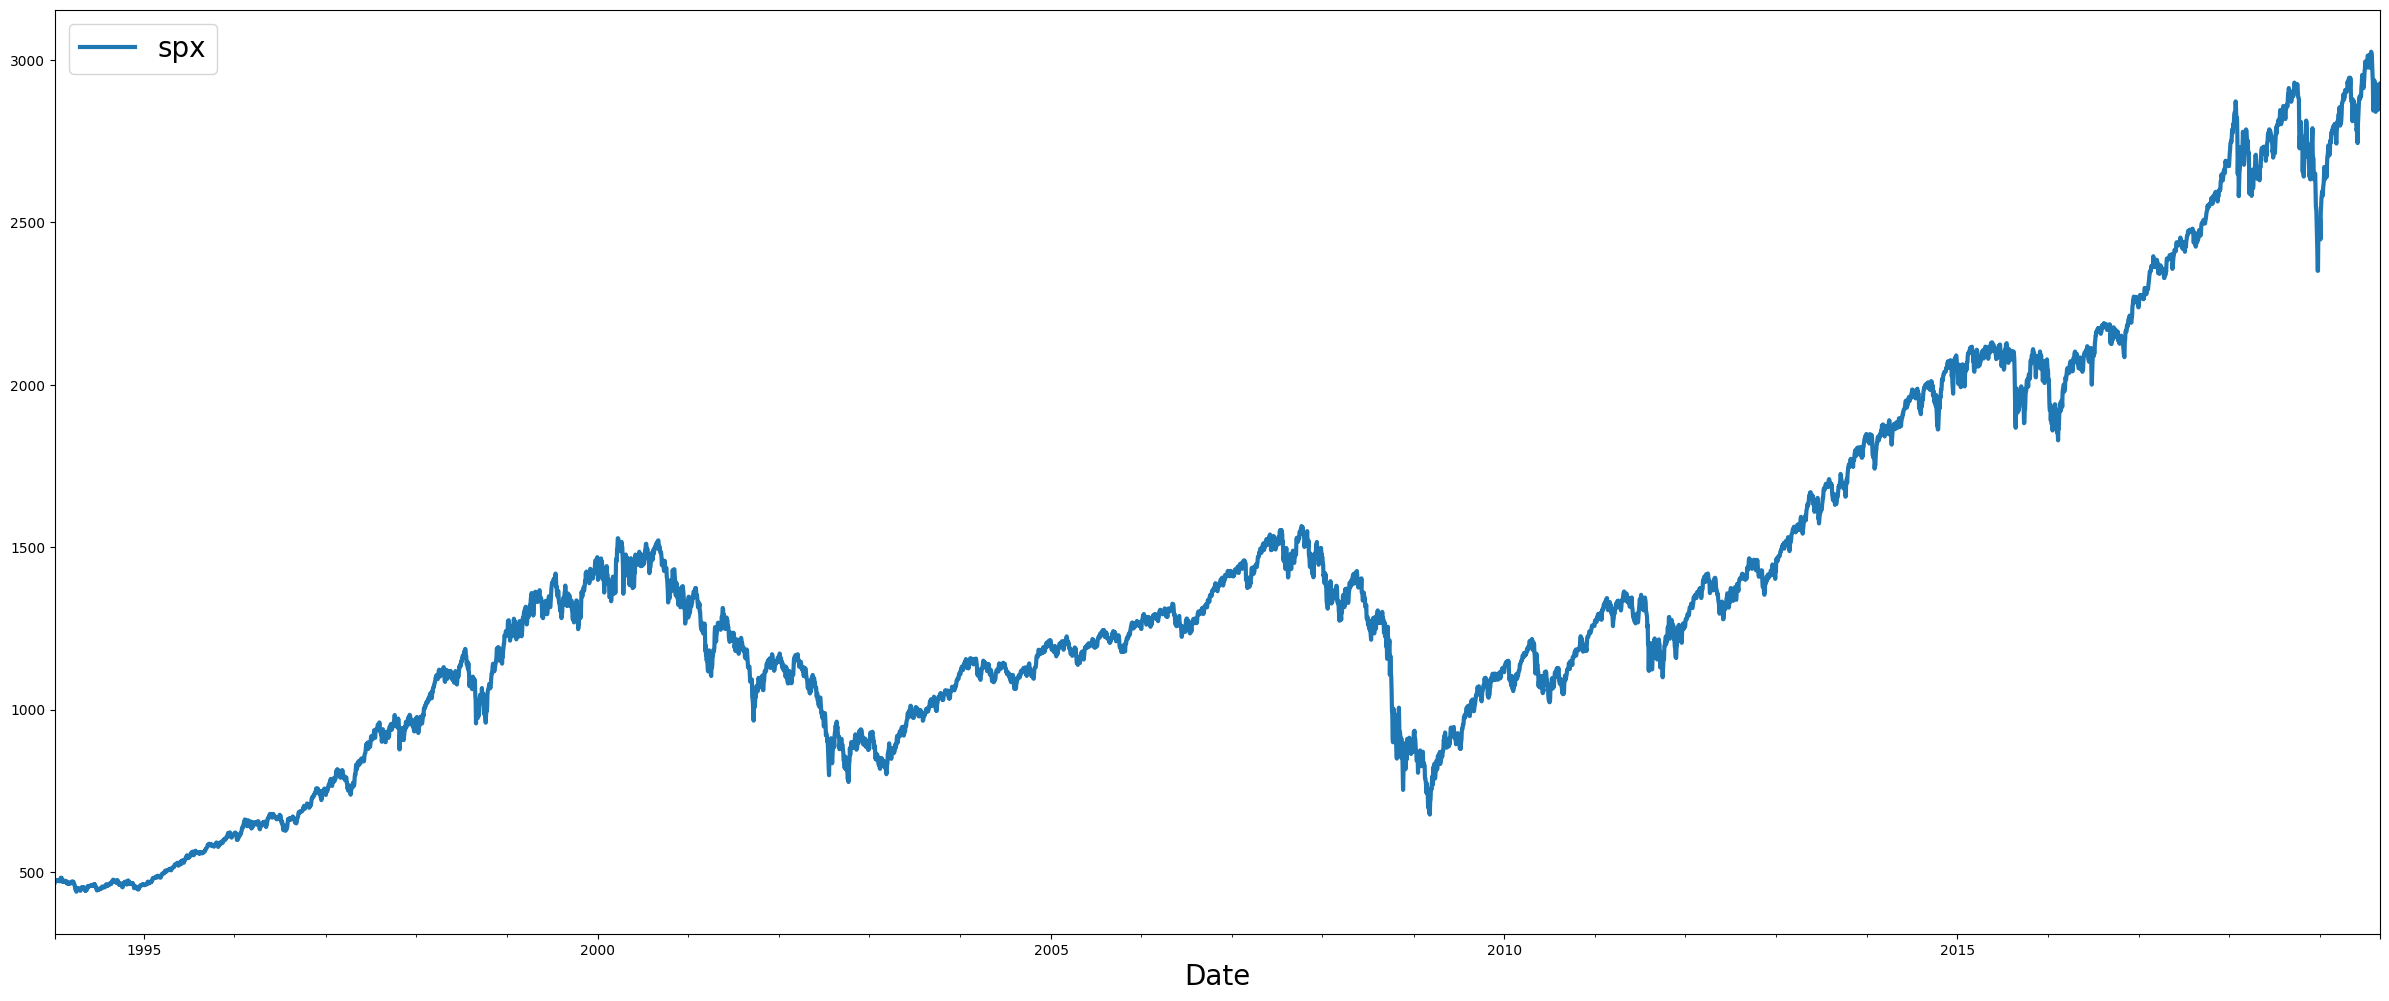

In [7]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [8]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

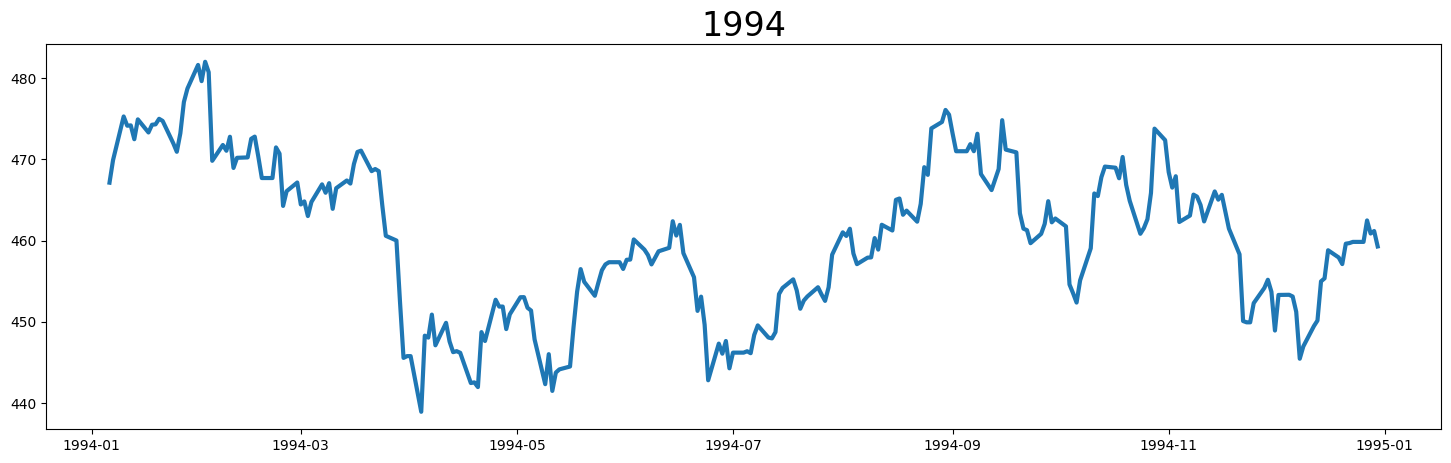

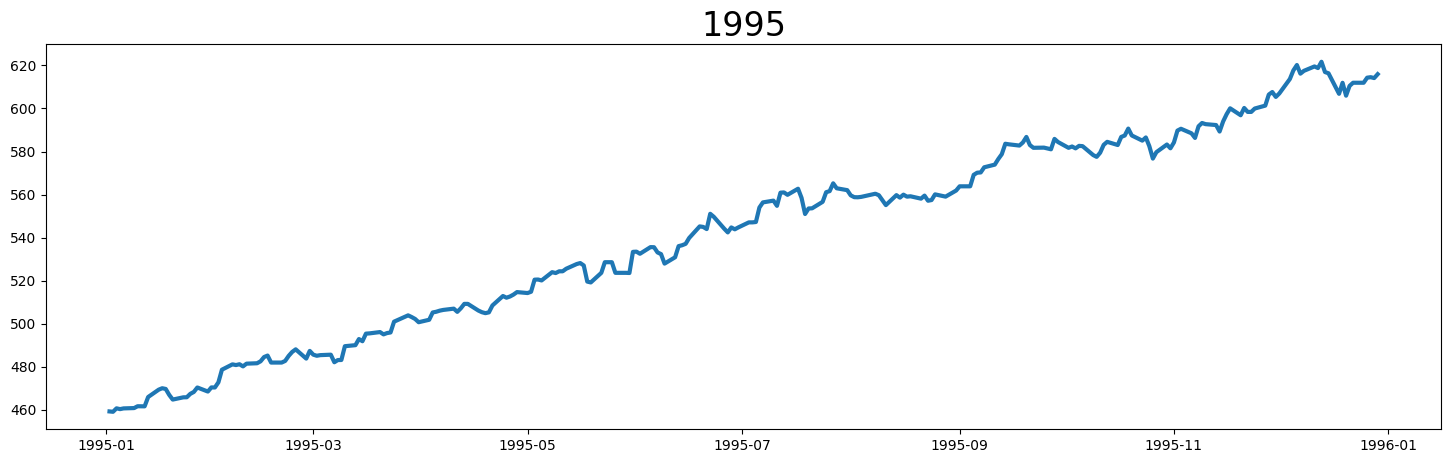

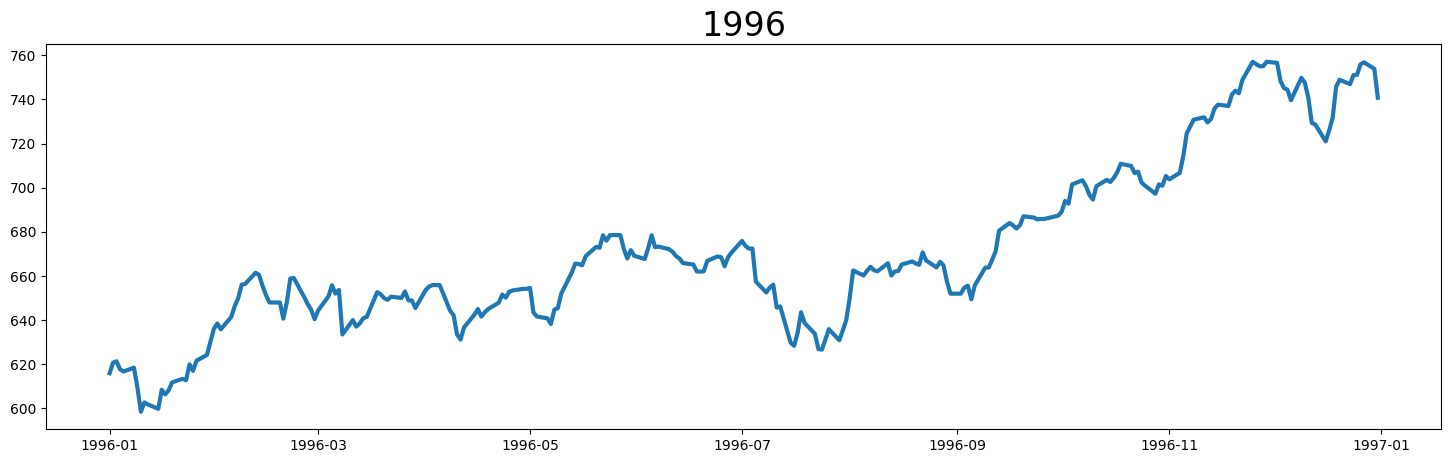

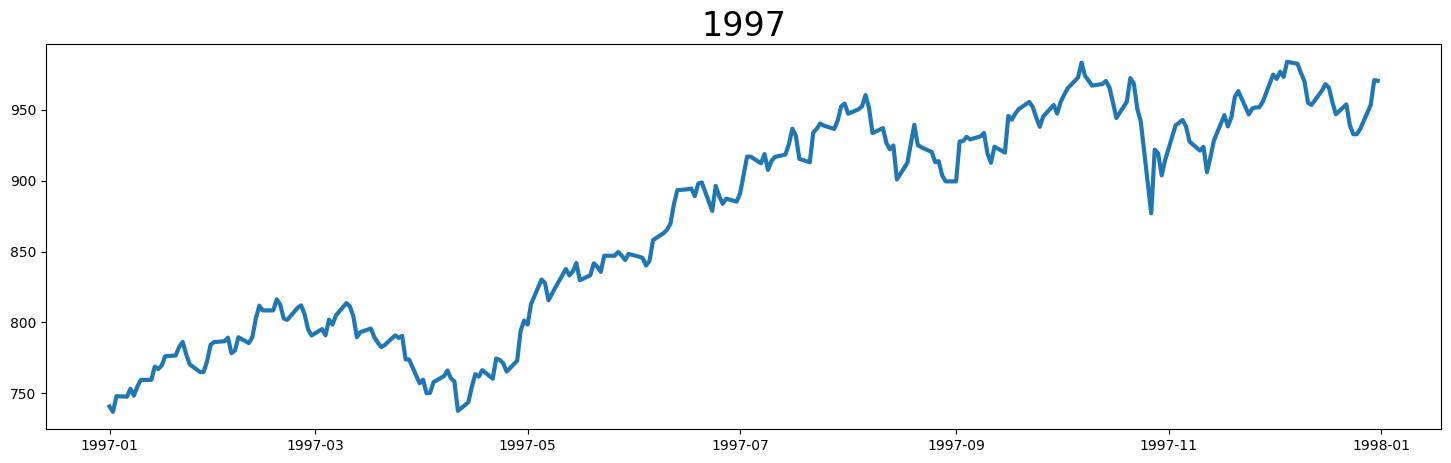

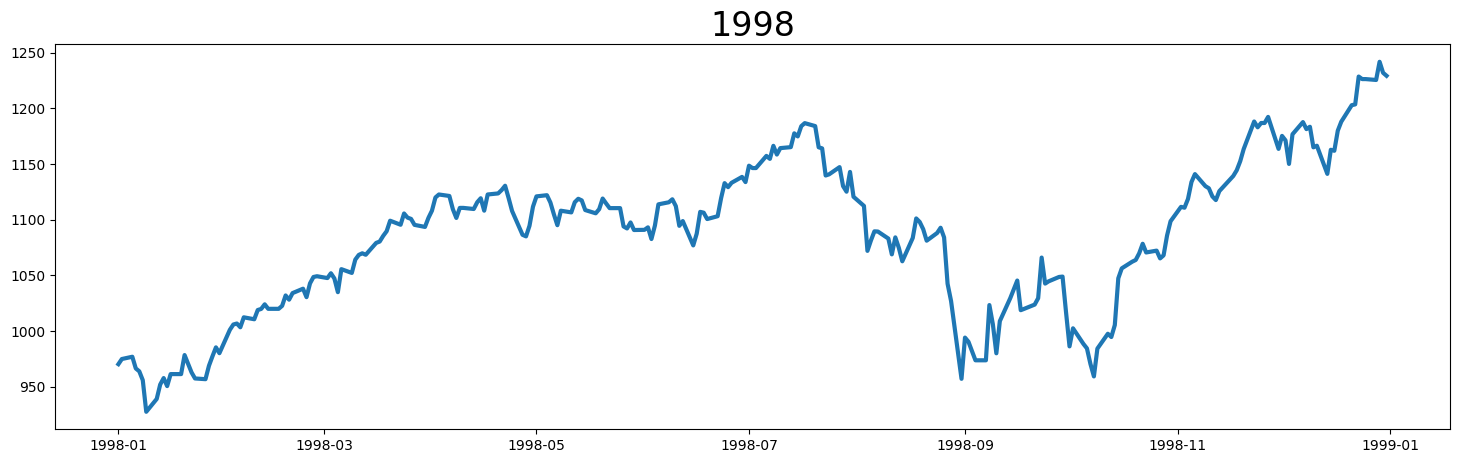

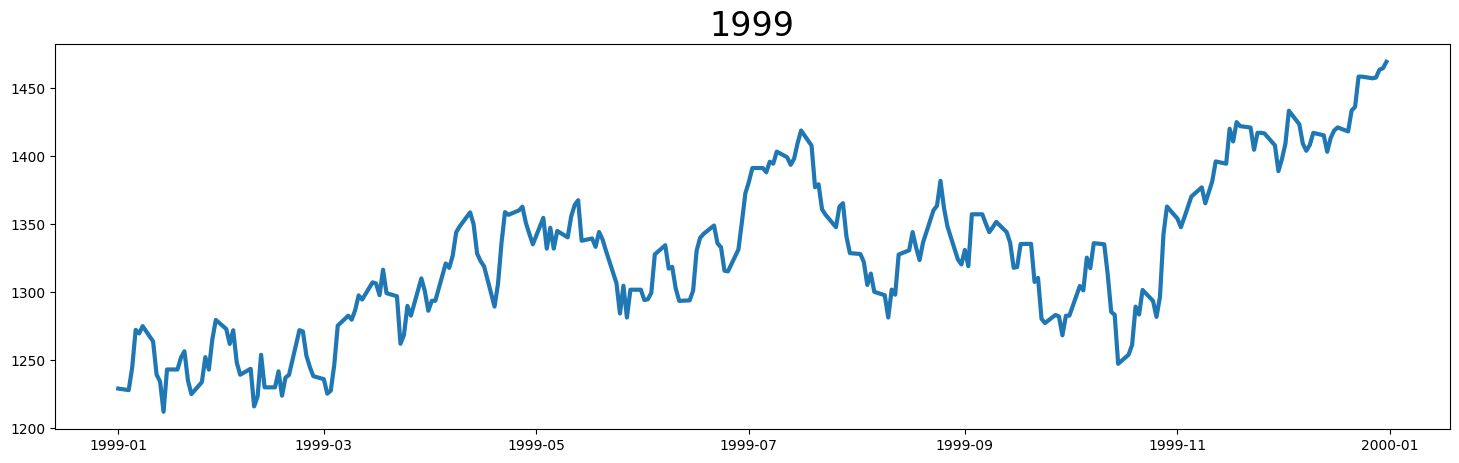

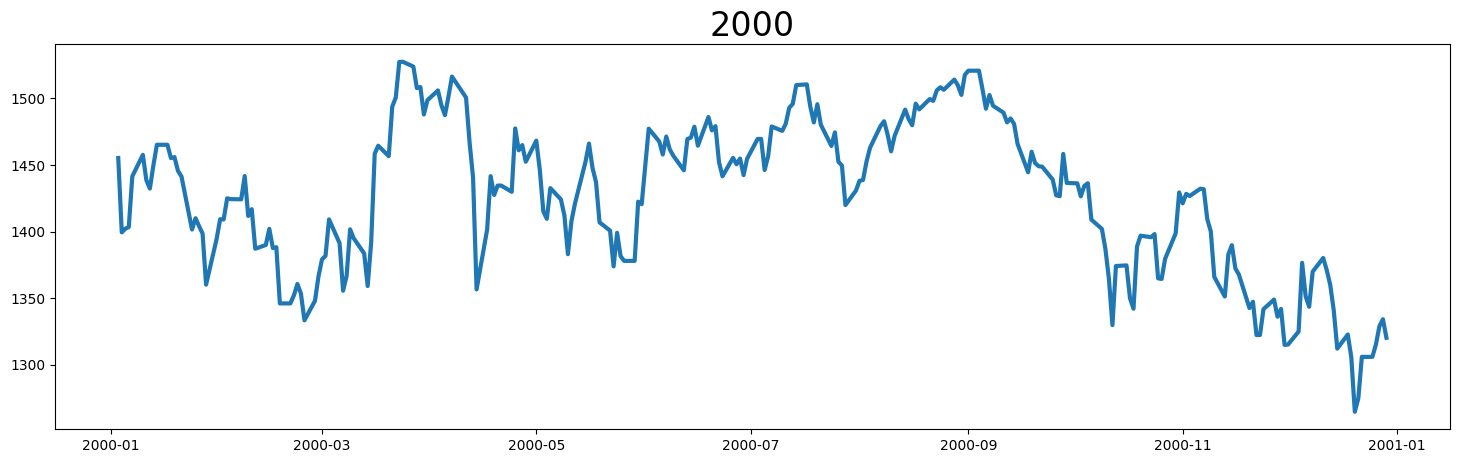

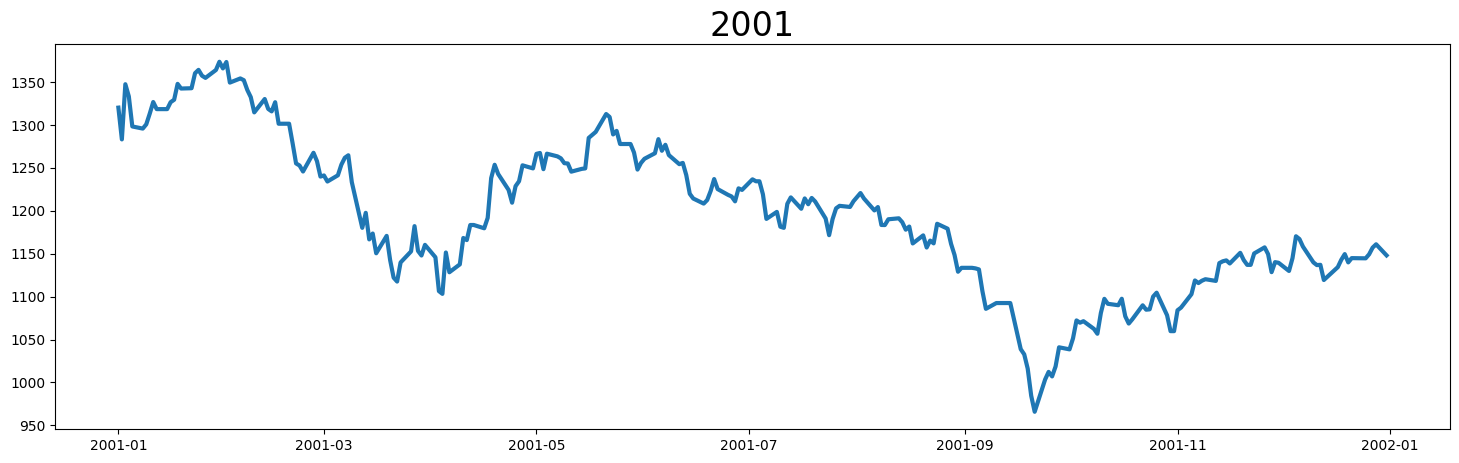

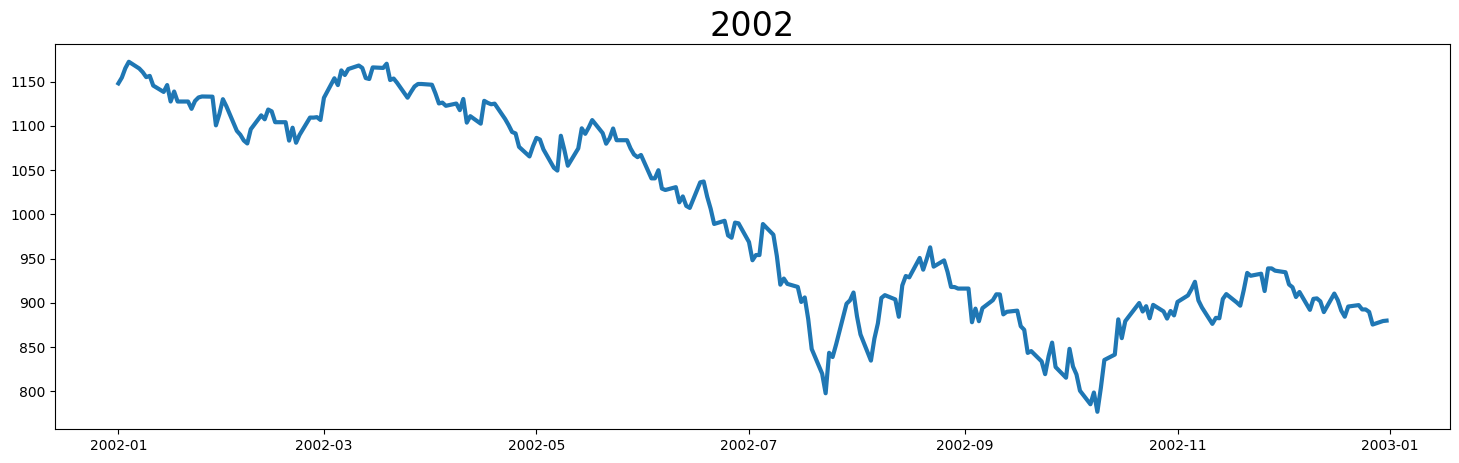

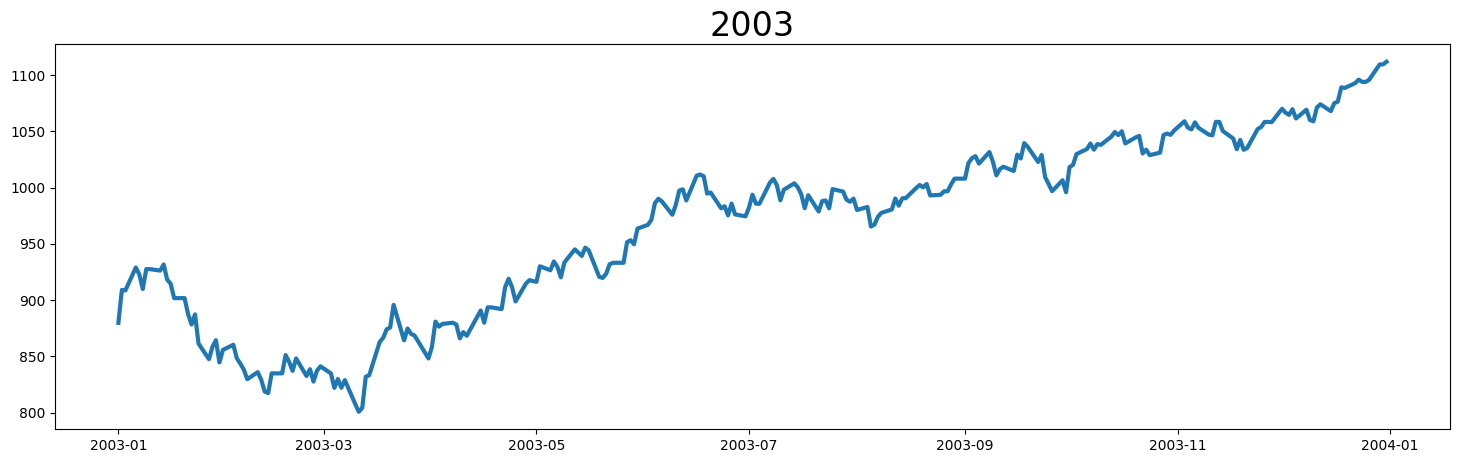

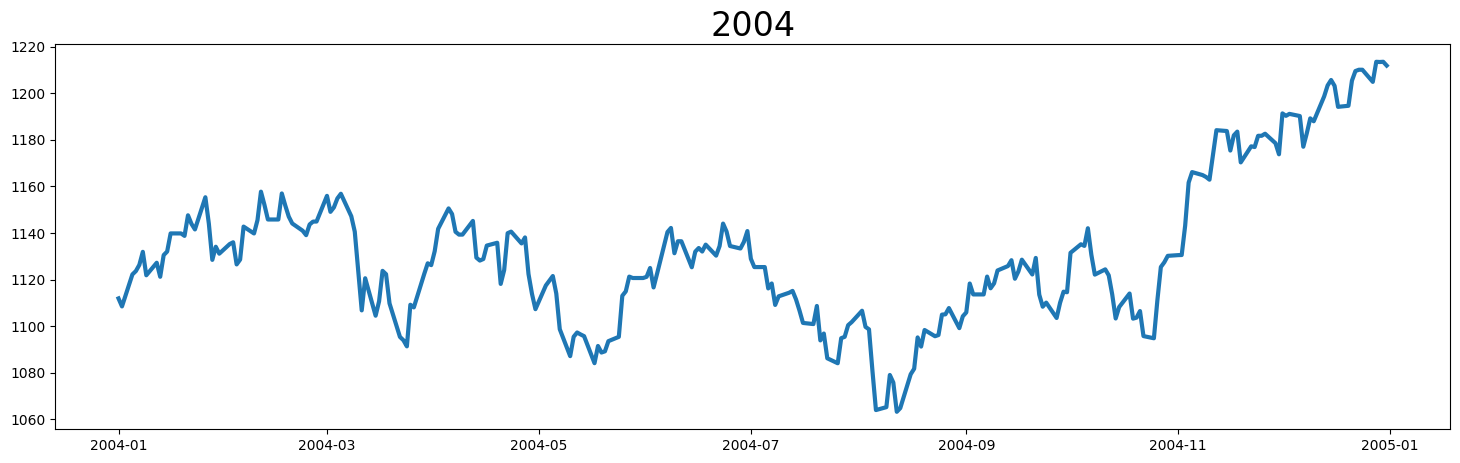

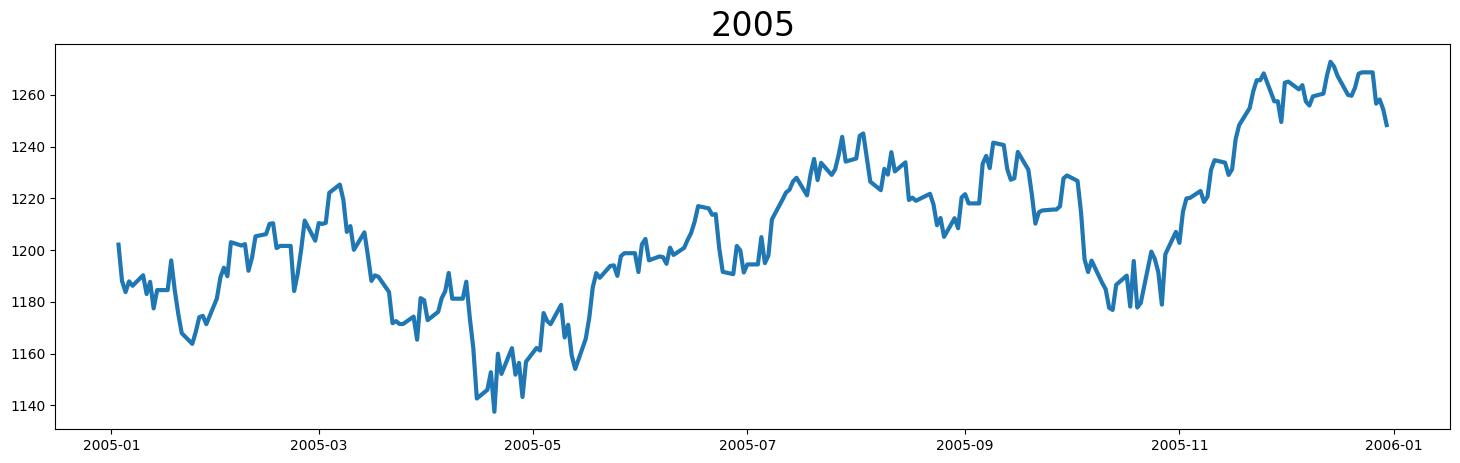

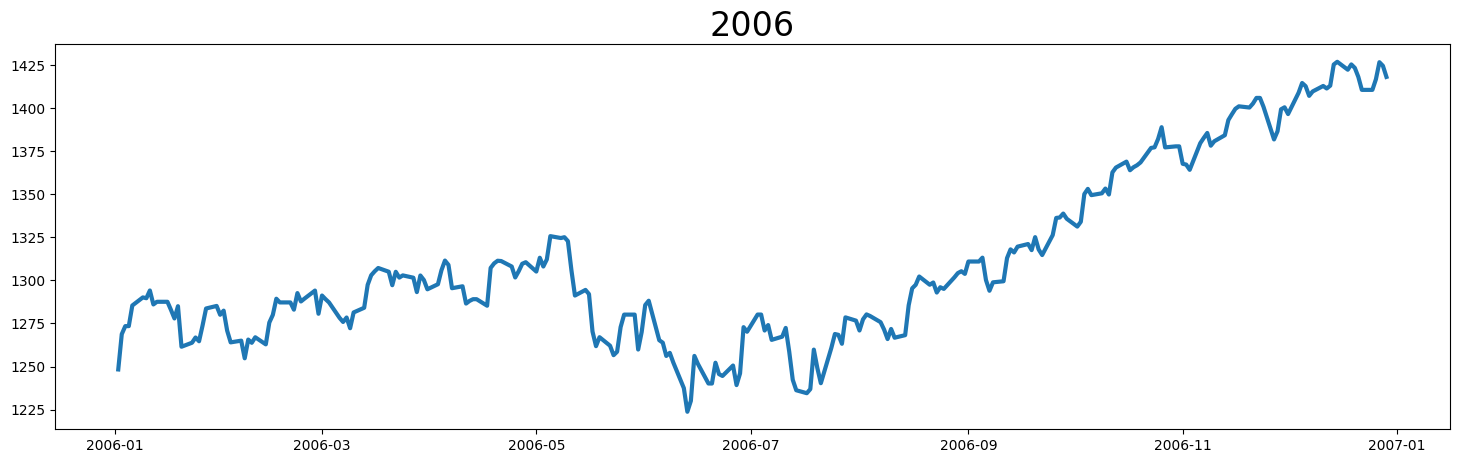

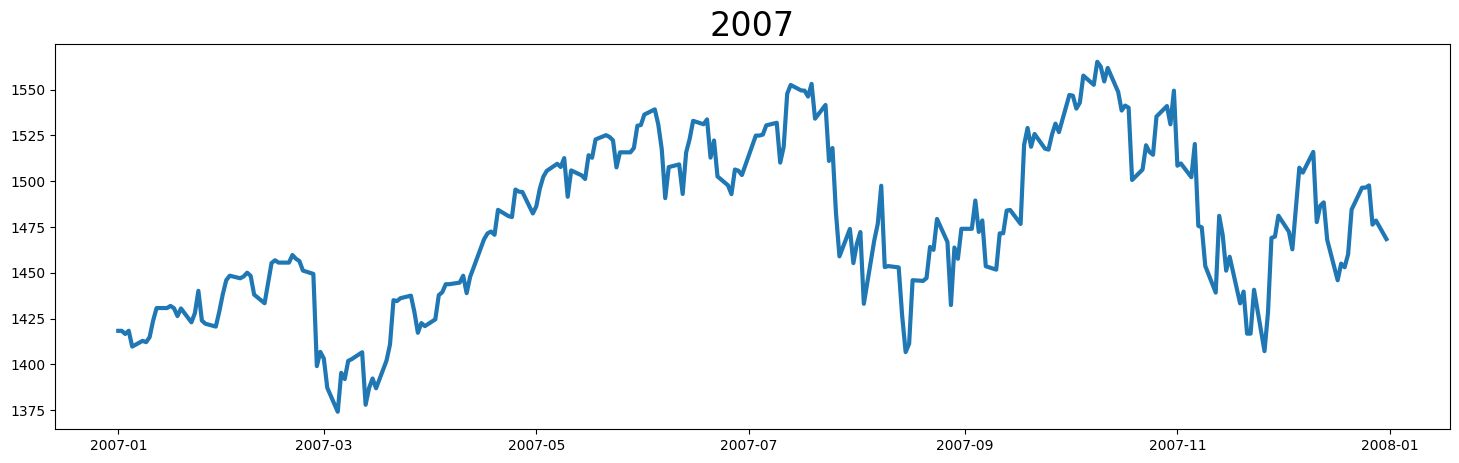

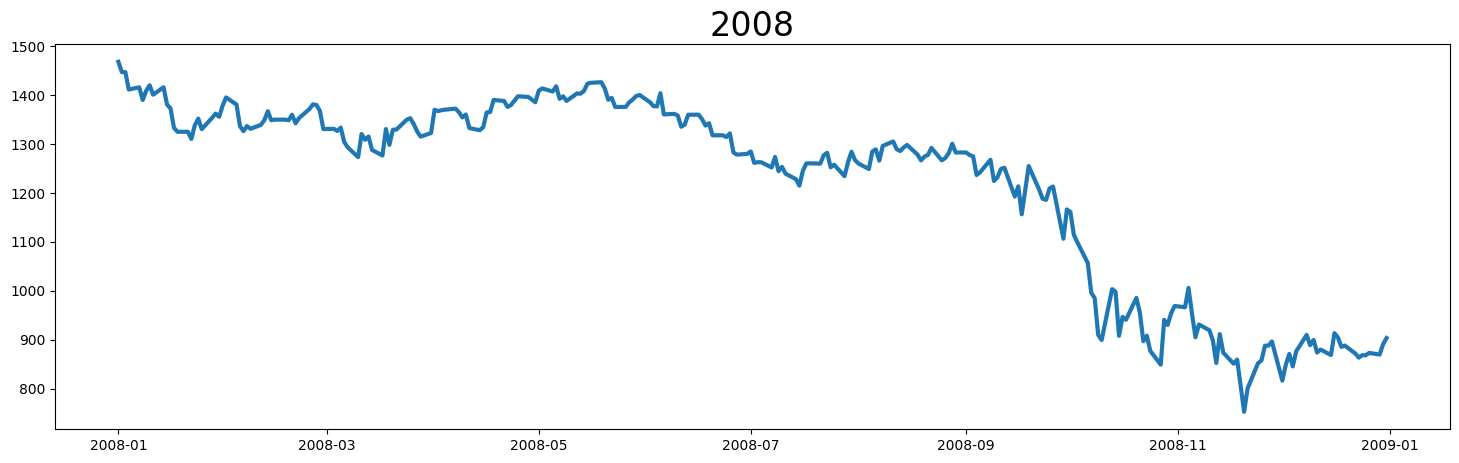

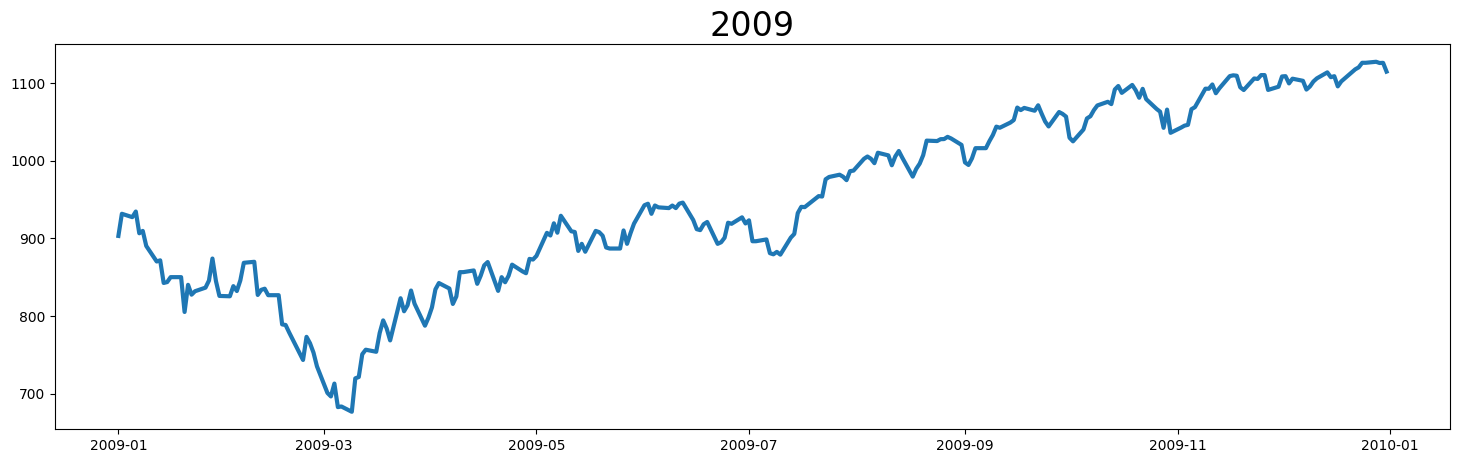

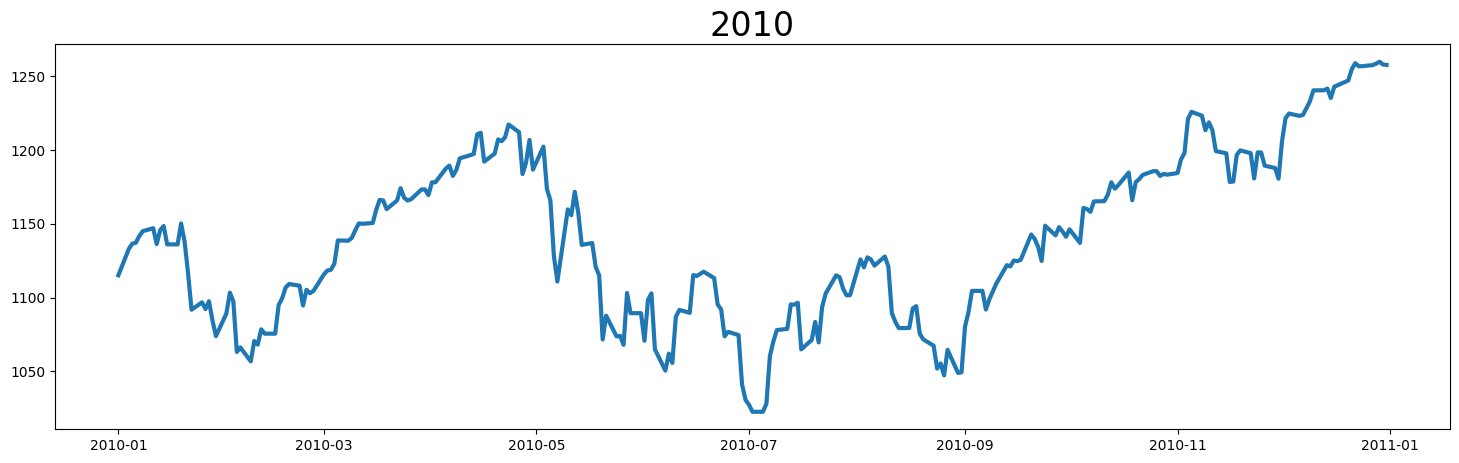

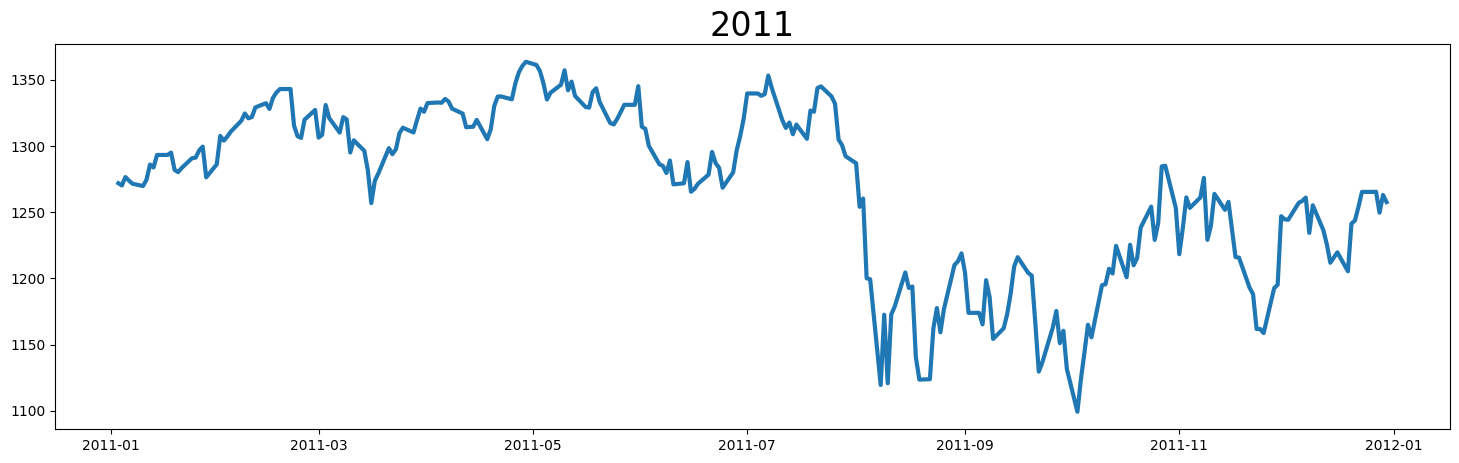

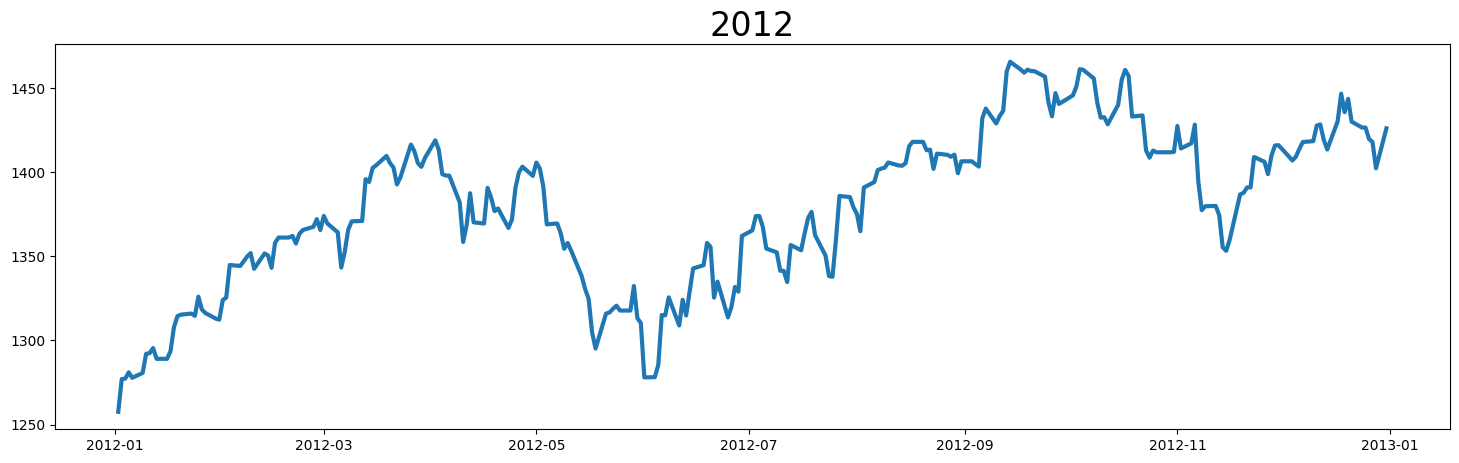

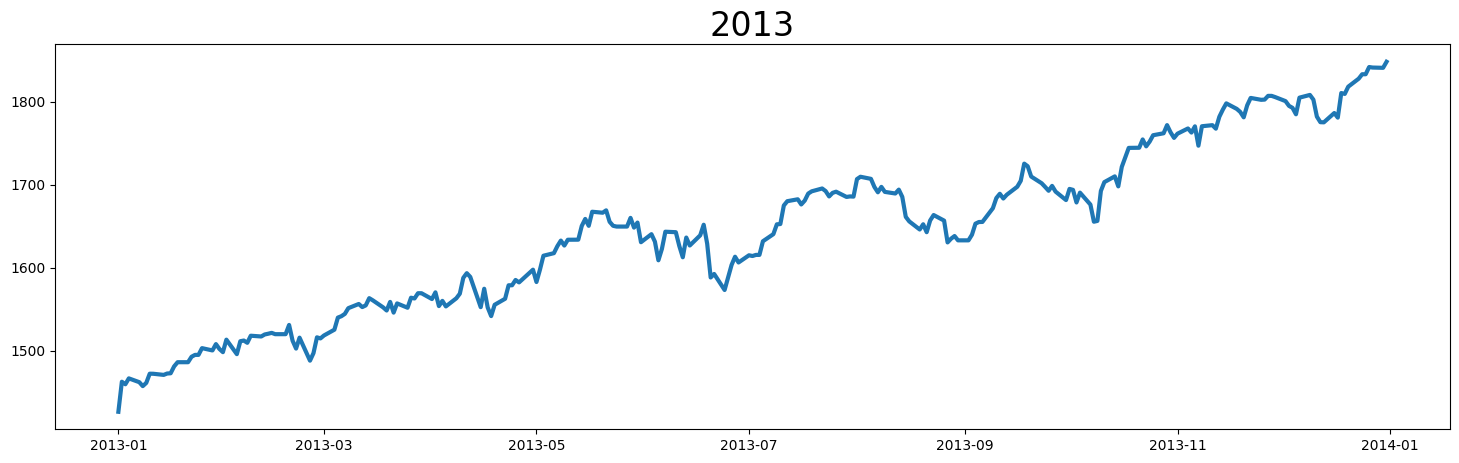

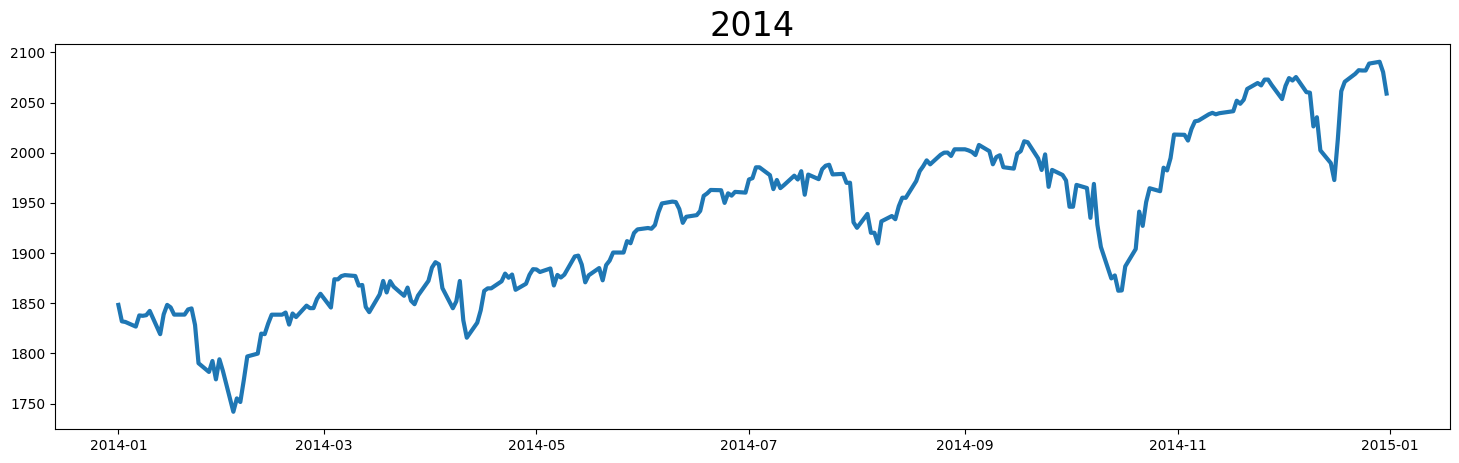

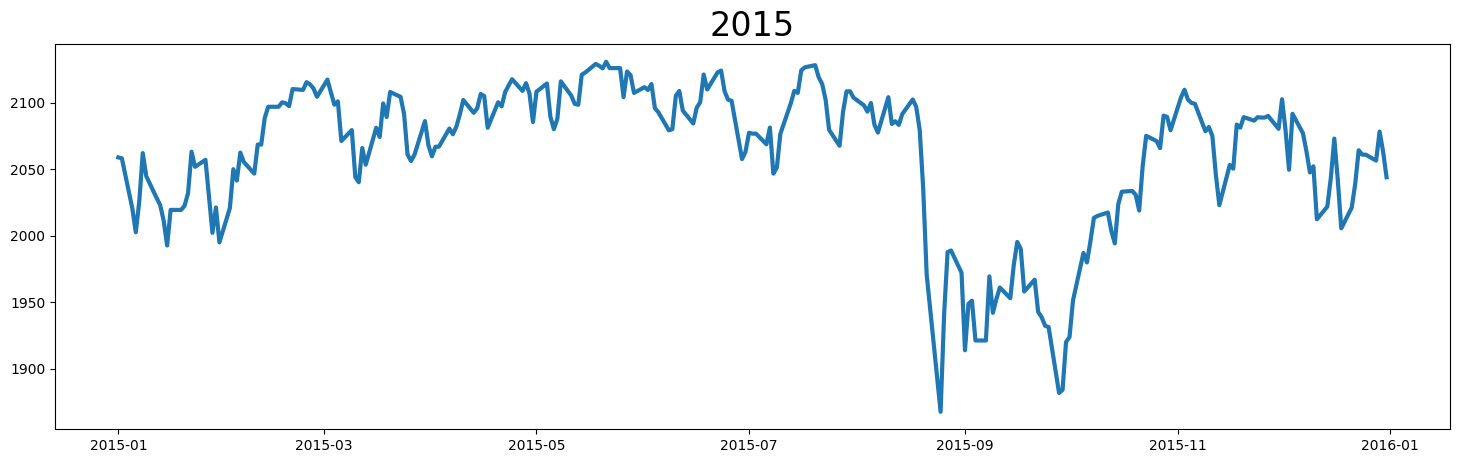

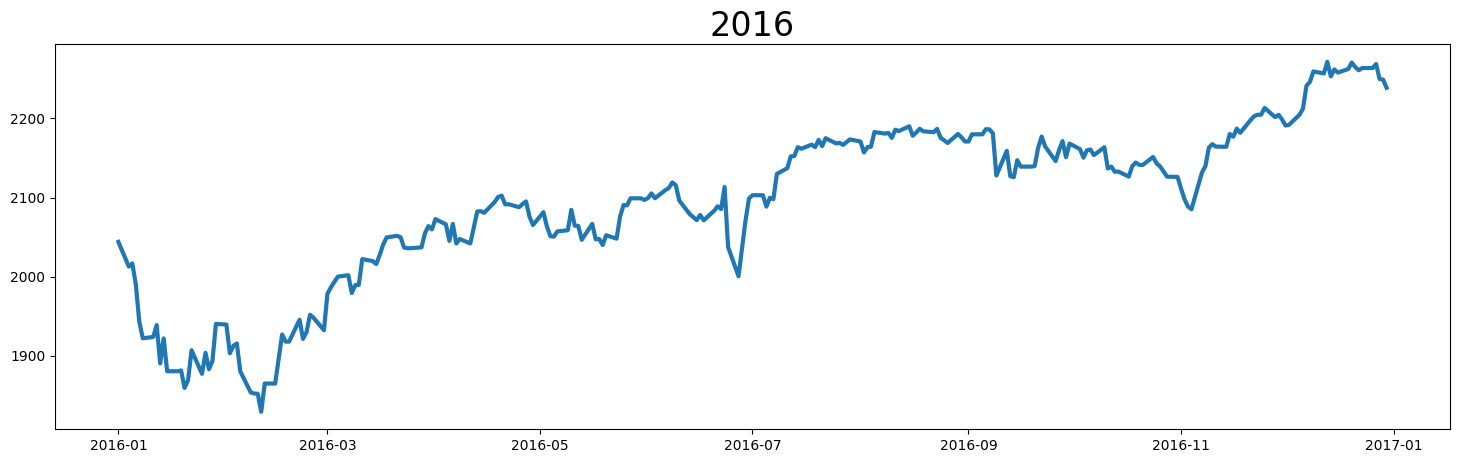

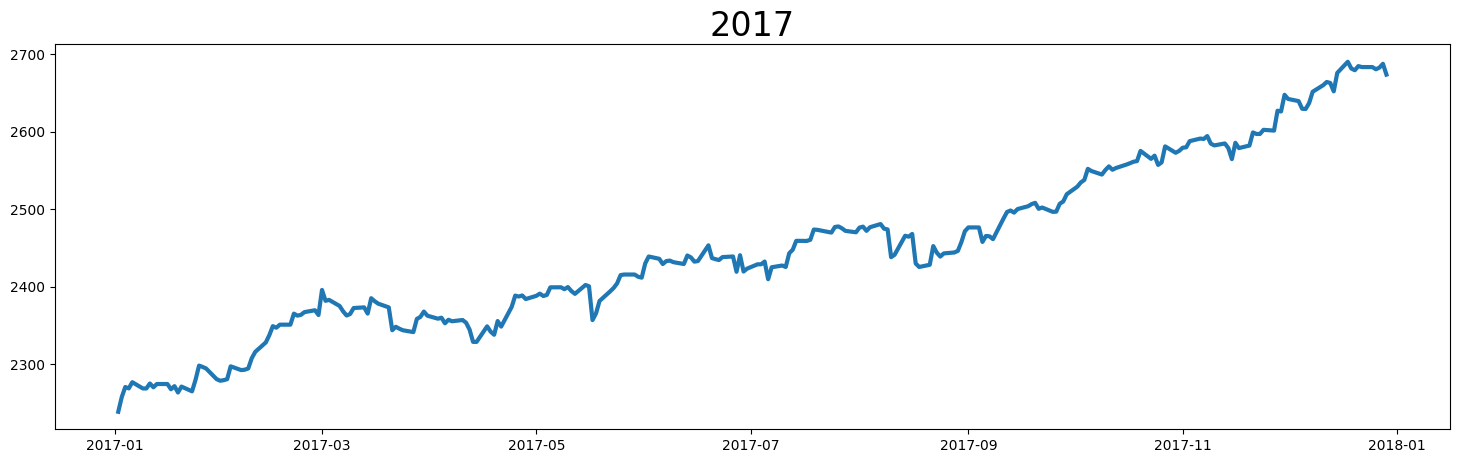

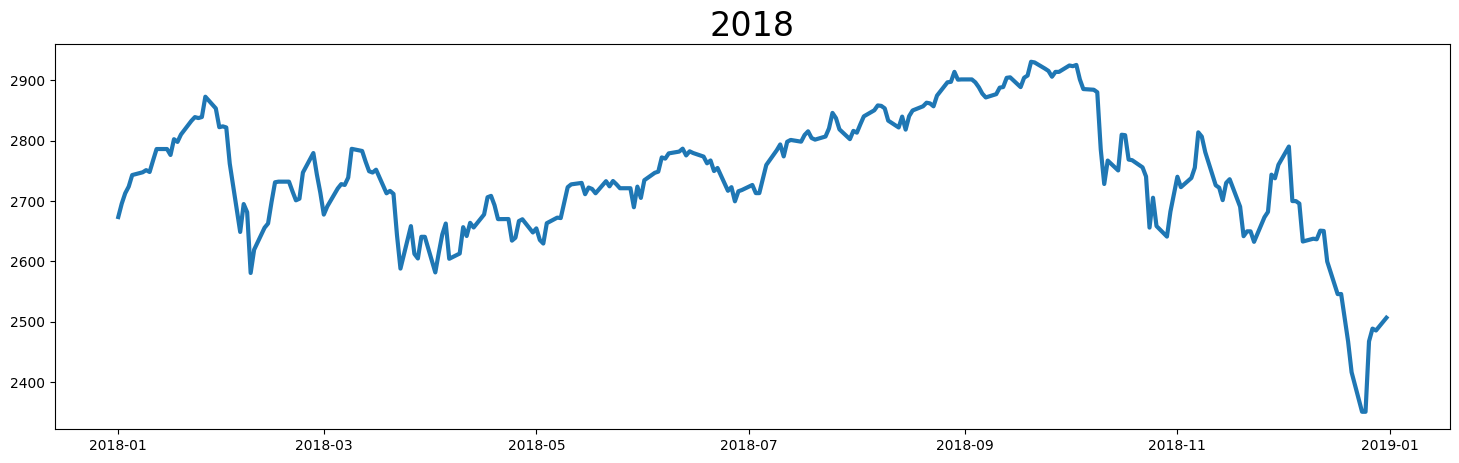

In [9]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[["spx"]].loc[train_df.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

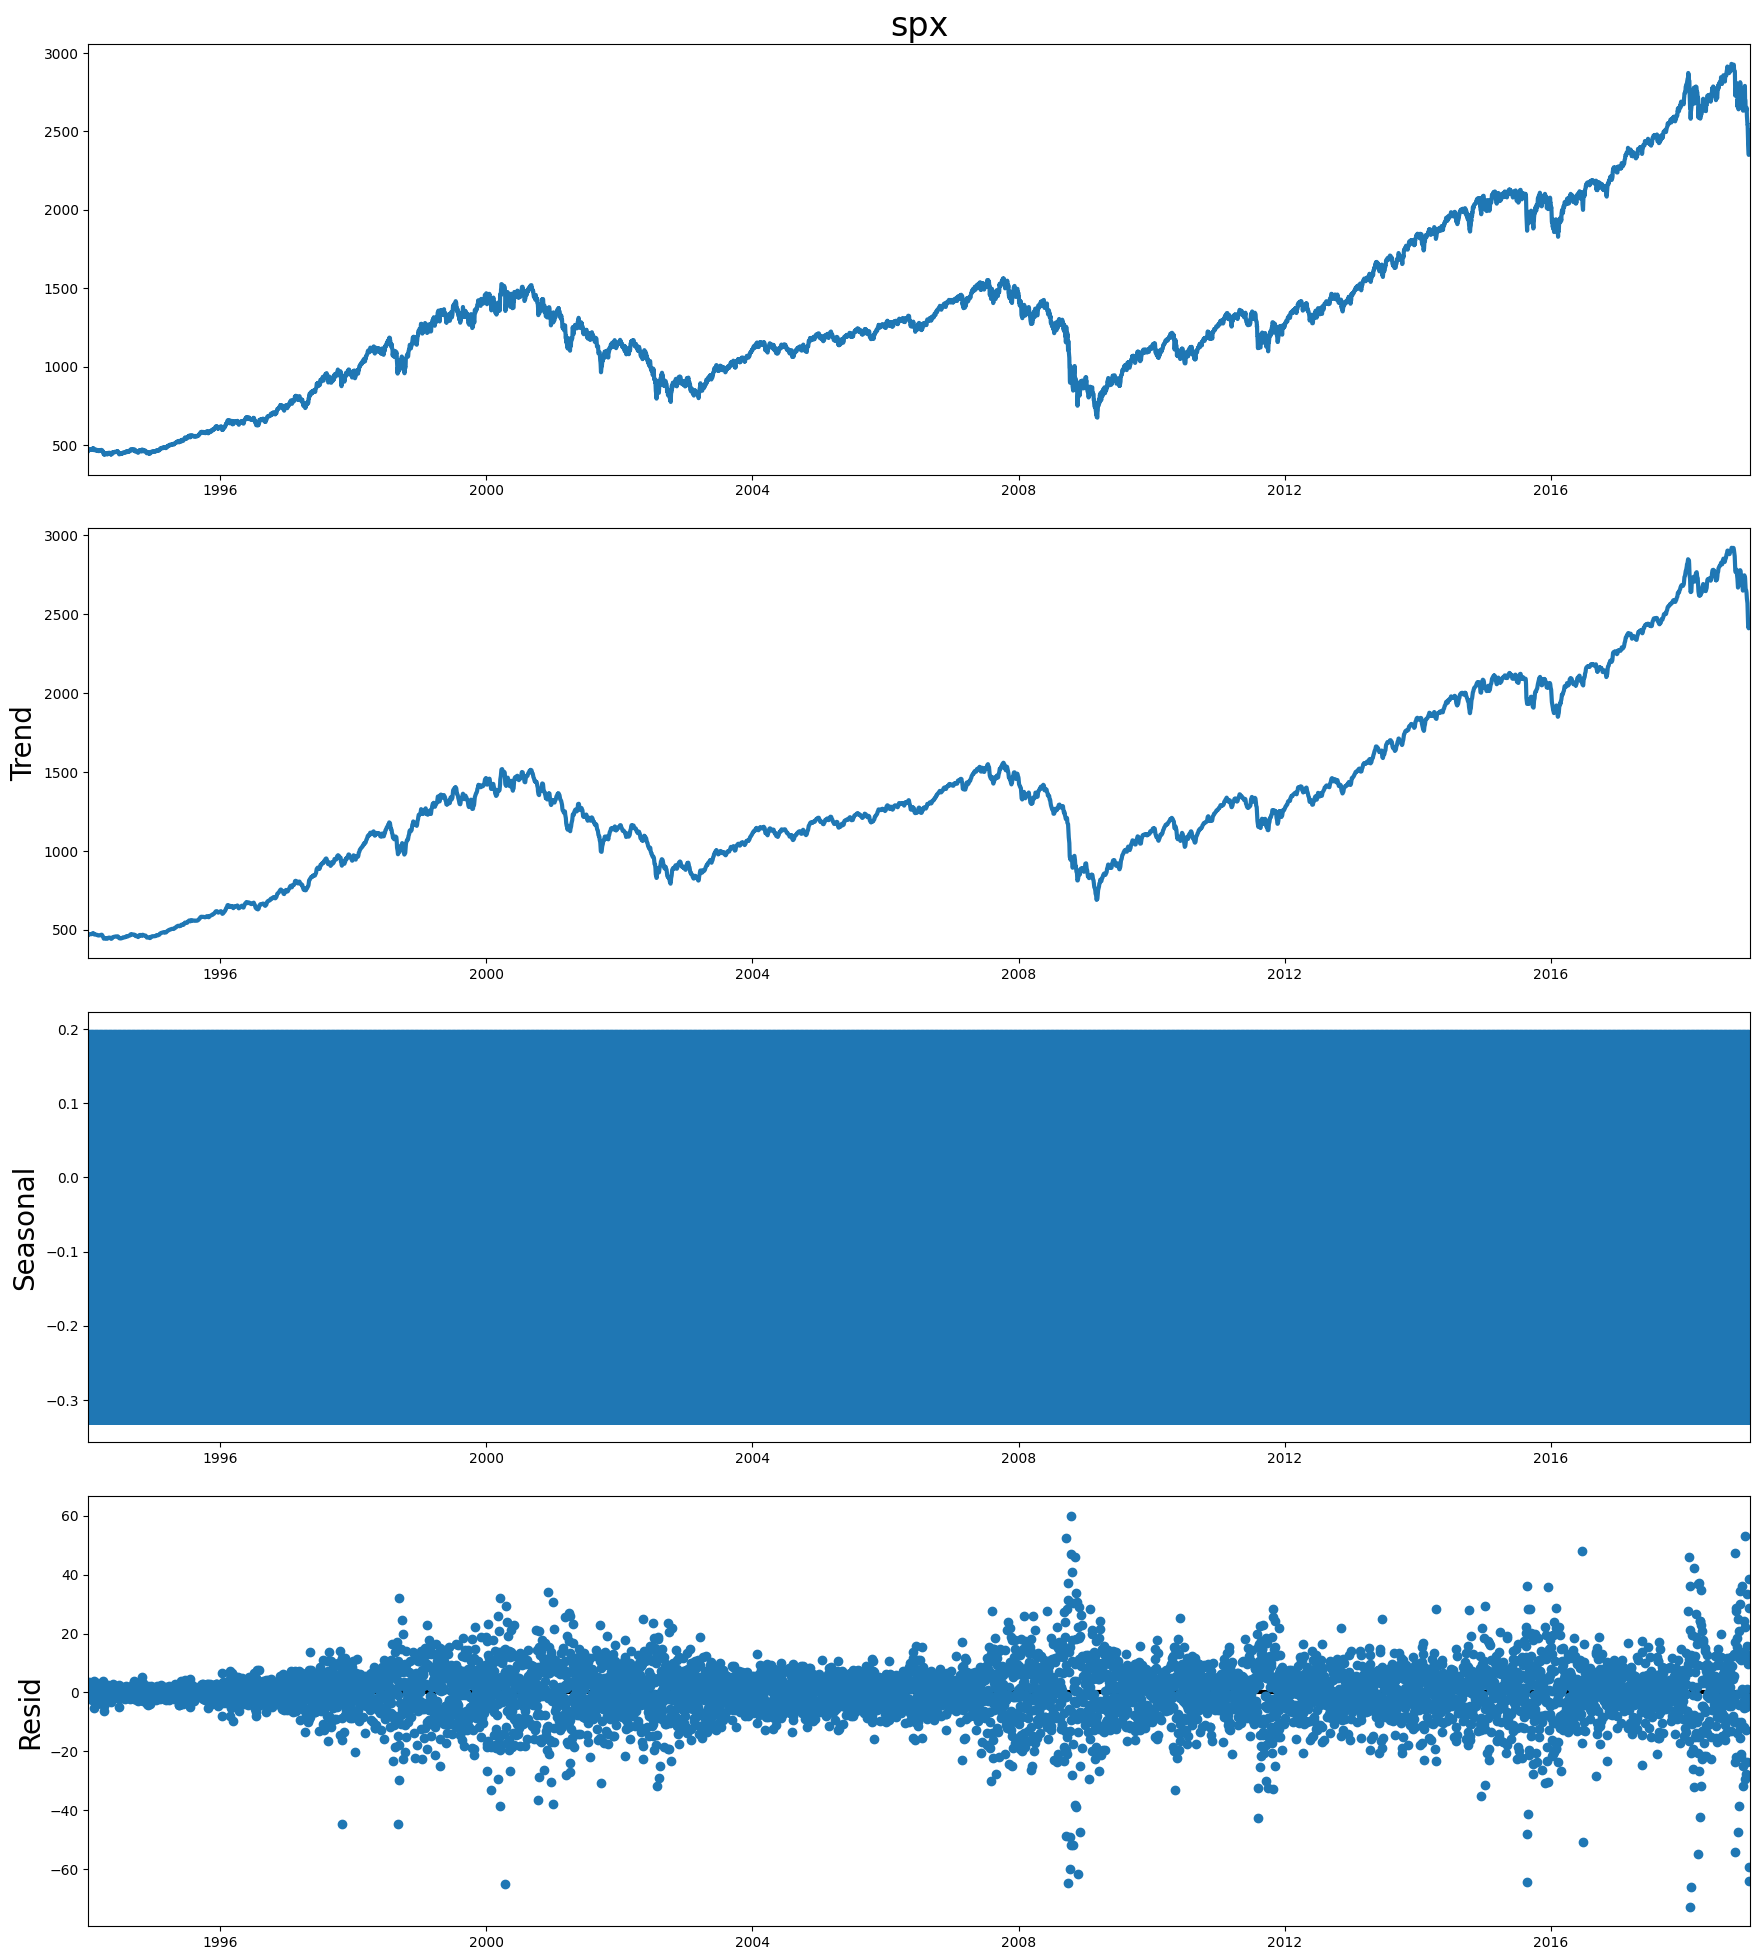

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.spx)
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

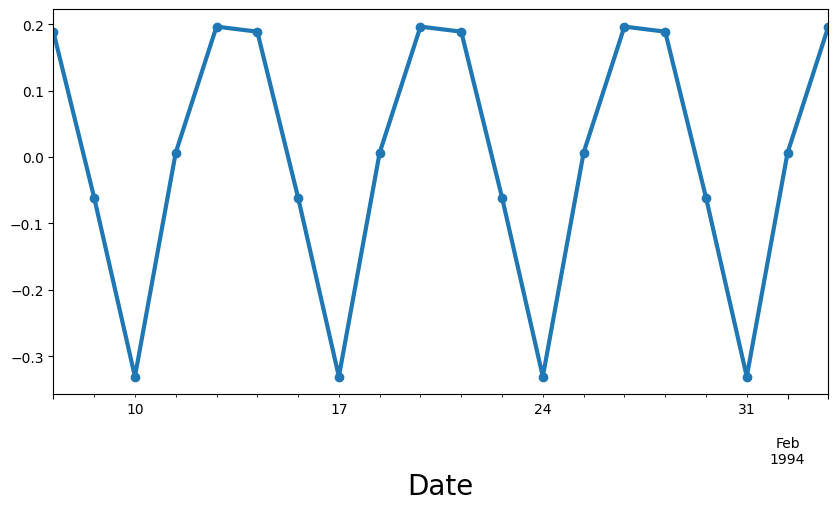

In [11]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

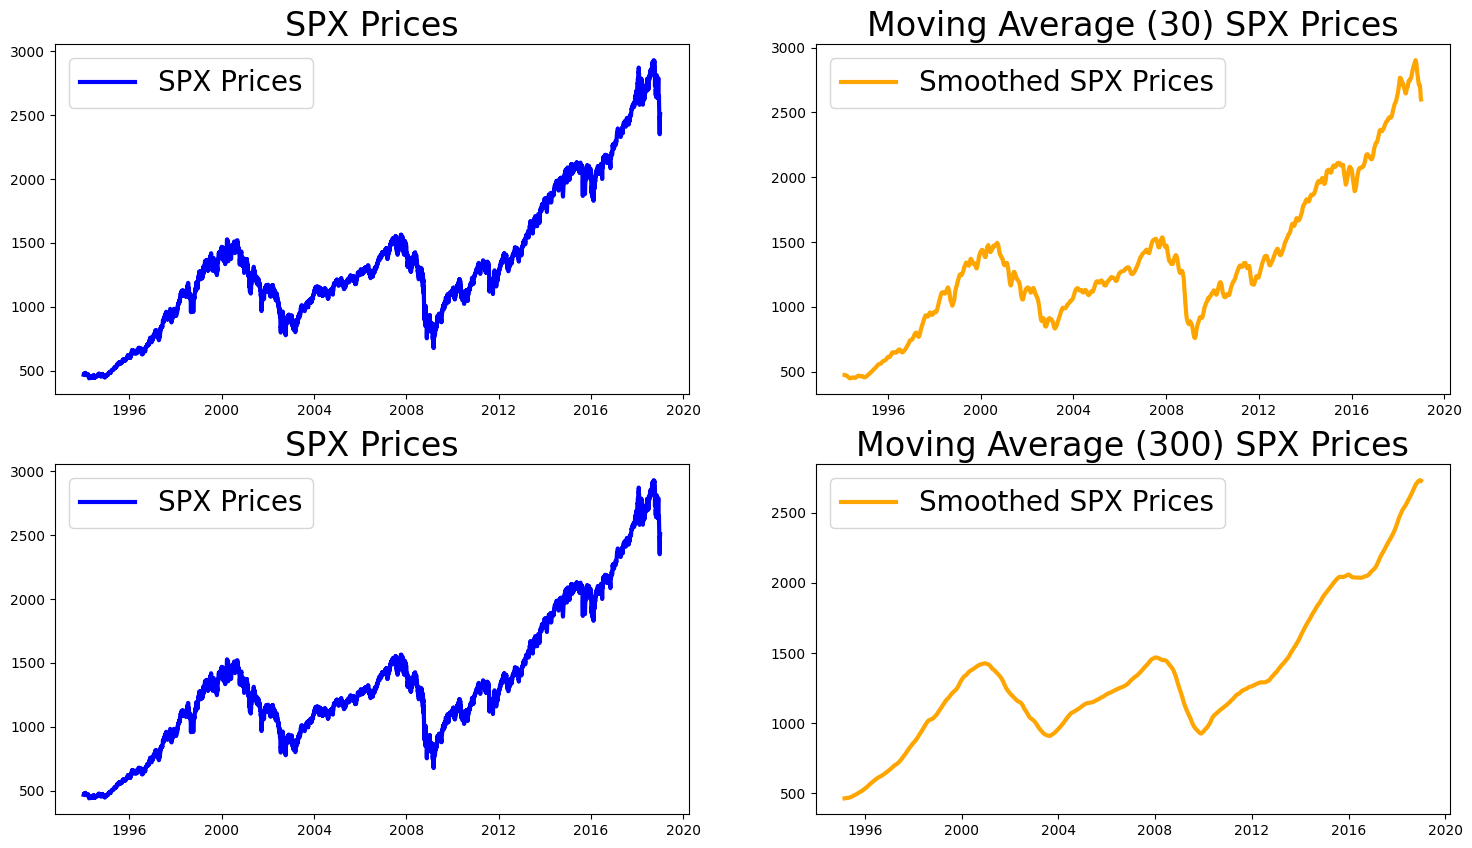

In [12]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[0, 0].set_title("SPX Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.spx.rolling(window=30).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (30) SPX Prices", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[1, 0].set_title("SPX Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.spx.rolling(window=300).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (300) SPX Prices", size=24)
ax[1, 1].legend()

plt.show()

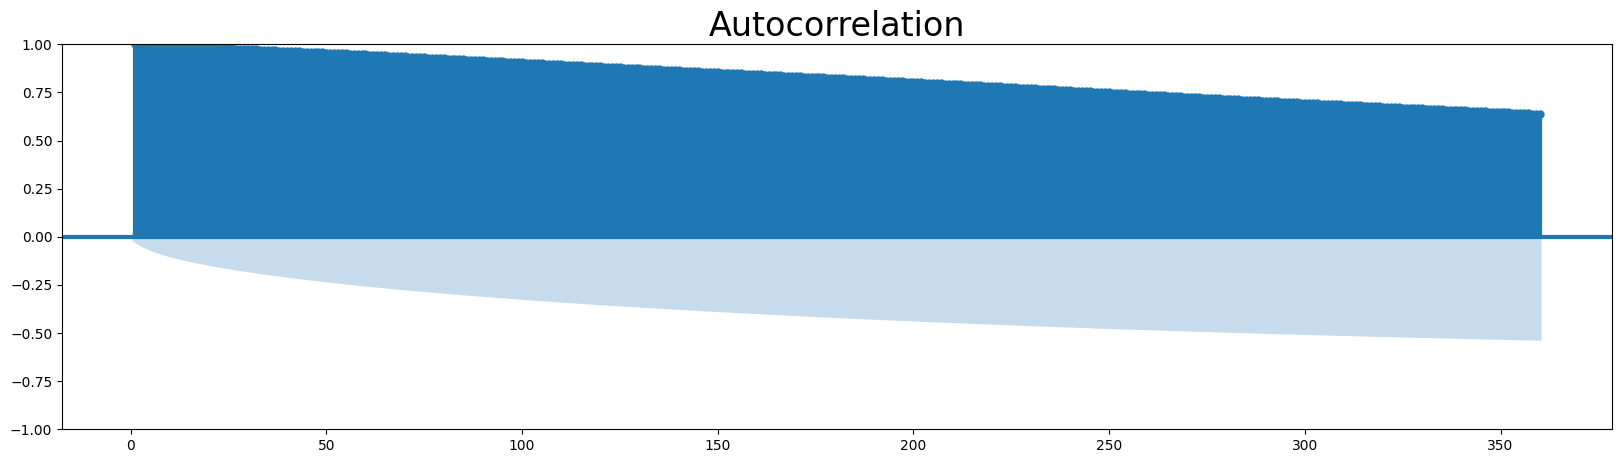

In [13]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.spx, lags=360, zero=False)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

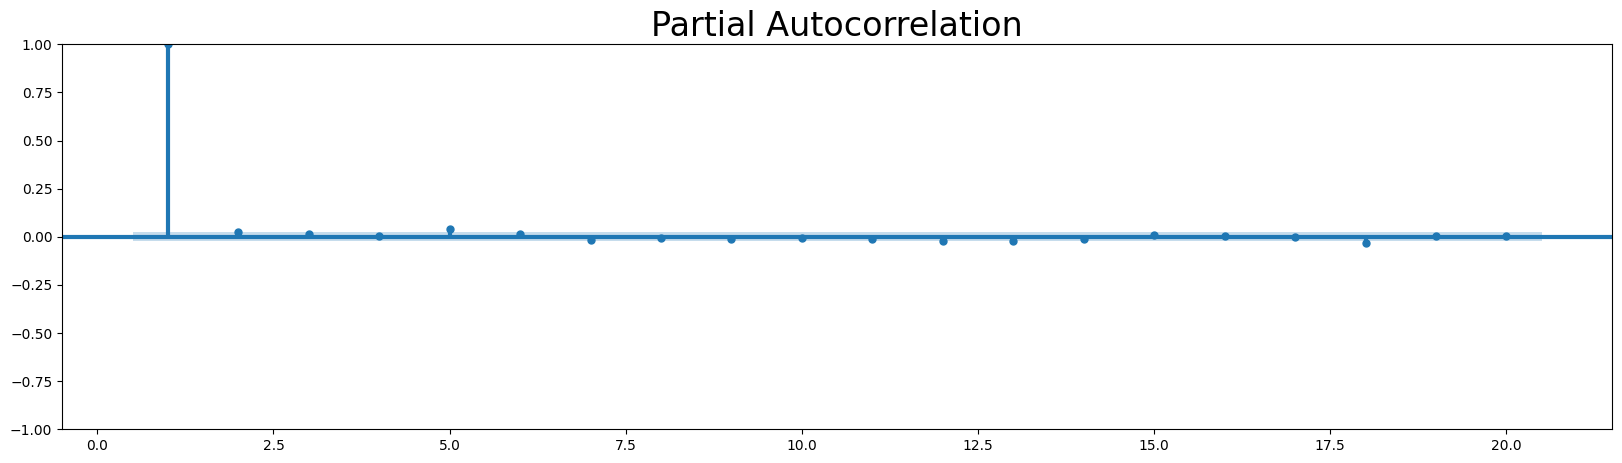

In [14]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.spx, lags=20, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [15]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["spx"])

(-0.33128093969652234,
 0.9209556878912161,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [16]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

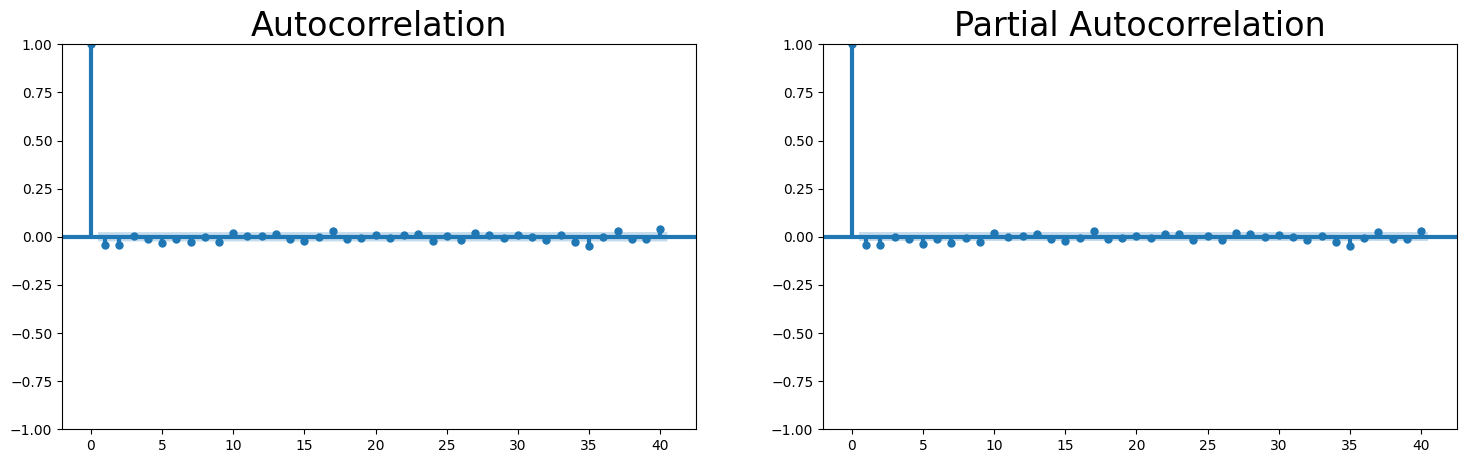

(-27.32625020173119,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [17]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [18]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Thu, 21 Sep 2023   AIC                          53257.350
Time:                        12:47:22   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_df["spx"].dropna(), order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26625.675
Date:                Thu, 21 Sep 2023   AIC                          53257.350
Time:                        12:47:25   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [20]:
seas_model = SARIMAX(
    train_df["spx"].dropna(), order=(1, 1, 2), seasonal_order=(1, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood              -26617.825
Date:                           Thu, 21 Sep 2023   AIC                          53249.649
Time:                                   12:48:25   BIC                          53297.119
Sample:                               01-06-1994   HQIC                         53266.066
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1711      0.167      1.023      0.306      -0.157       0.499
ma.L1         -0.2140      0.166     -1.286      0.199      -0.540       0.112
ma.L2         -0.0328      0.012     -2.847      0.004      -0.055      -0.010
ar.S.L5       -0.7762      0.080     -9.650      0.000      -0.934      -0.619
ma.S.L5       -0.2545      0.085     -3.009      0.003      -0.420      -0.089
ma.S.L10      -0.7448      0.085     -8.735      0.000      -0.912      -0.578
sigma2       206.8983      2.061    100.391      0.000     202.859     210.938
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11682.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

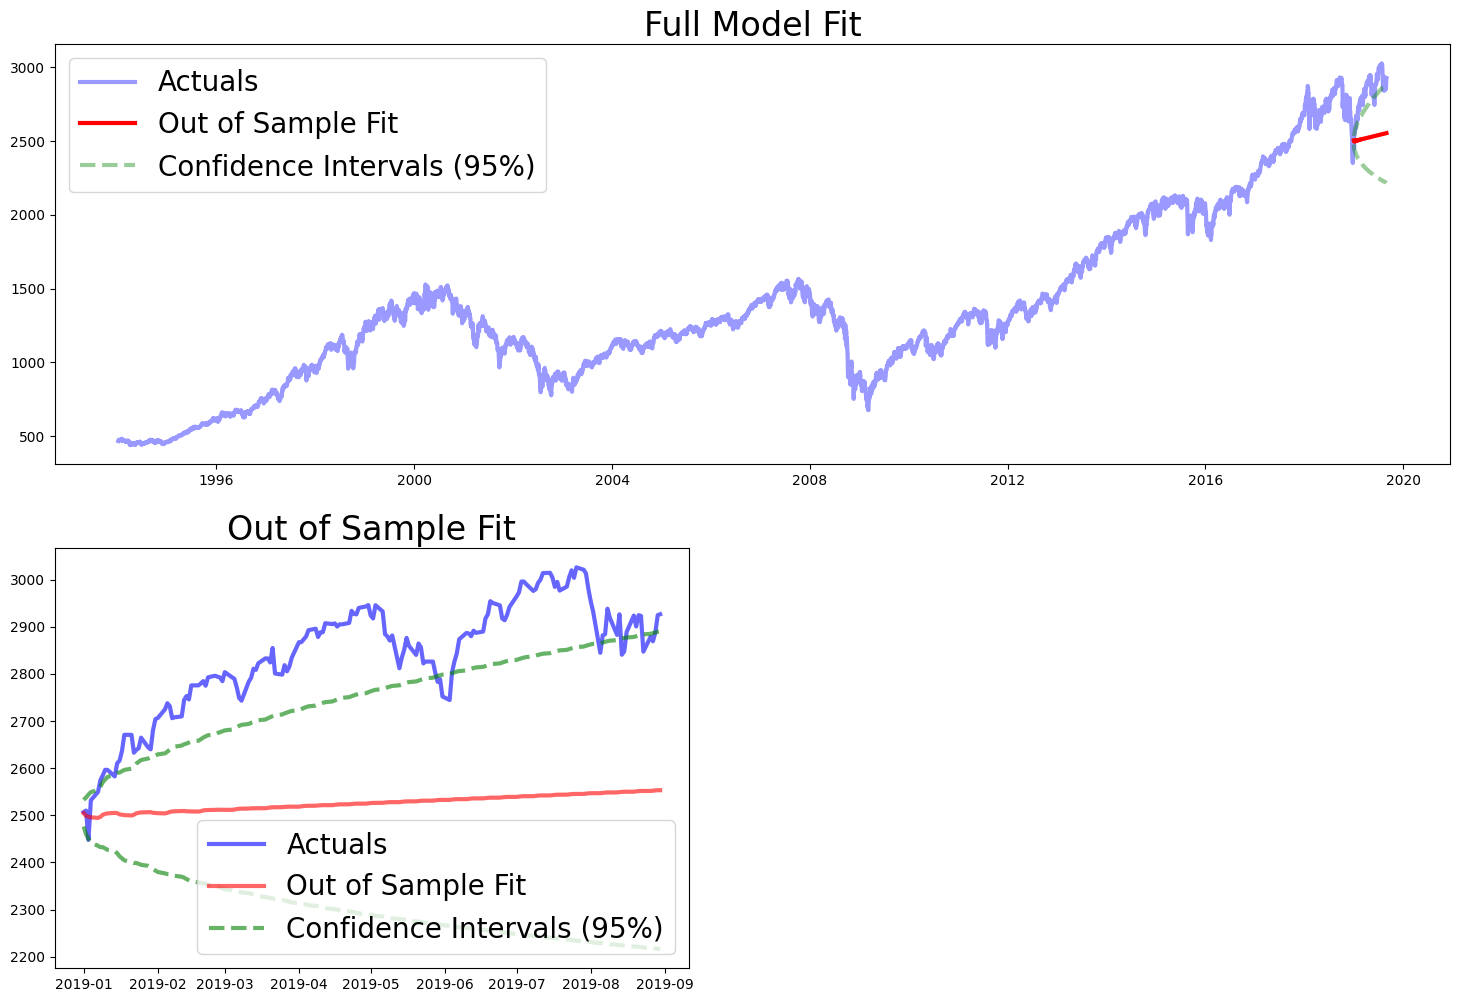

In [22]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [23]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=18.21 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=1.14 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=2.83 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=10.35 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=1.03 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=4.45 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=30.16 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=17.34 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=3.69 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=6.55 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=4.33 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=35.41 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=24.74 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=6.79 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Thu, 21 Sep 2023   AIC                          55124.504
Time:                                   12:52:42   BIC                          55158.411
Sample:                               01-06-1994   HQIC                         55136.230
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Downsampling / Upsampling (Интерполяция)

In [24]:
print(data.shape)
data[(data.index > "2005-01-06") & (data.index < "2005-02-10")].head()

(6692, 1)


,spx
Date,
2005-01-07,1186.189941
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951


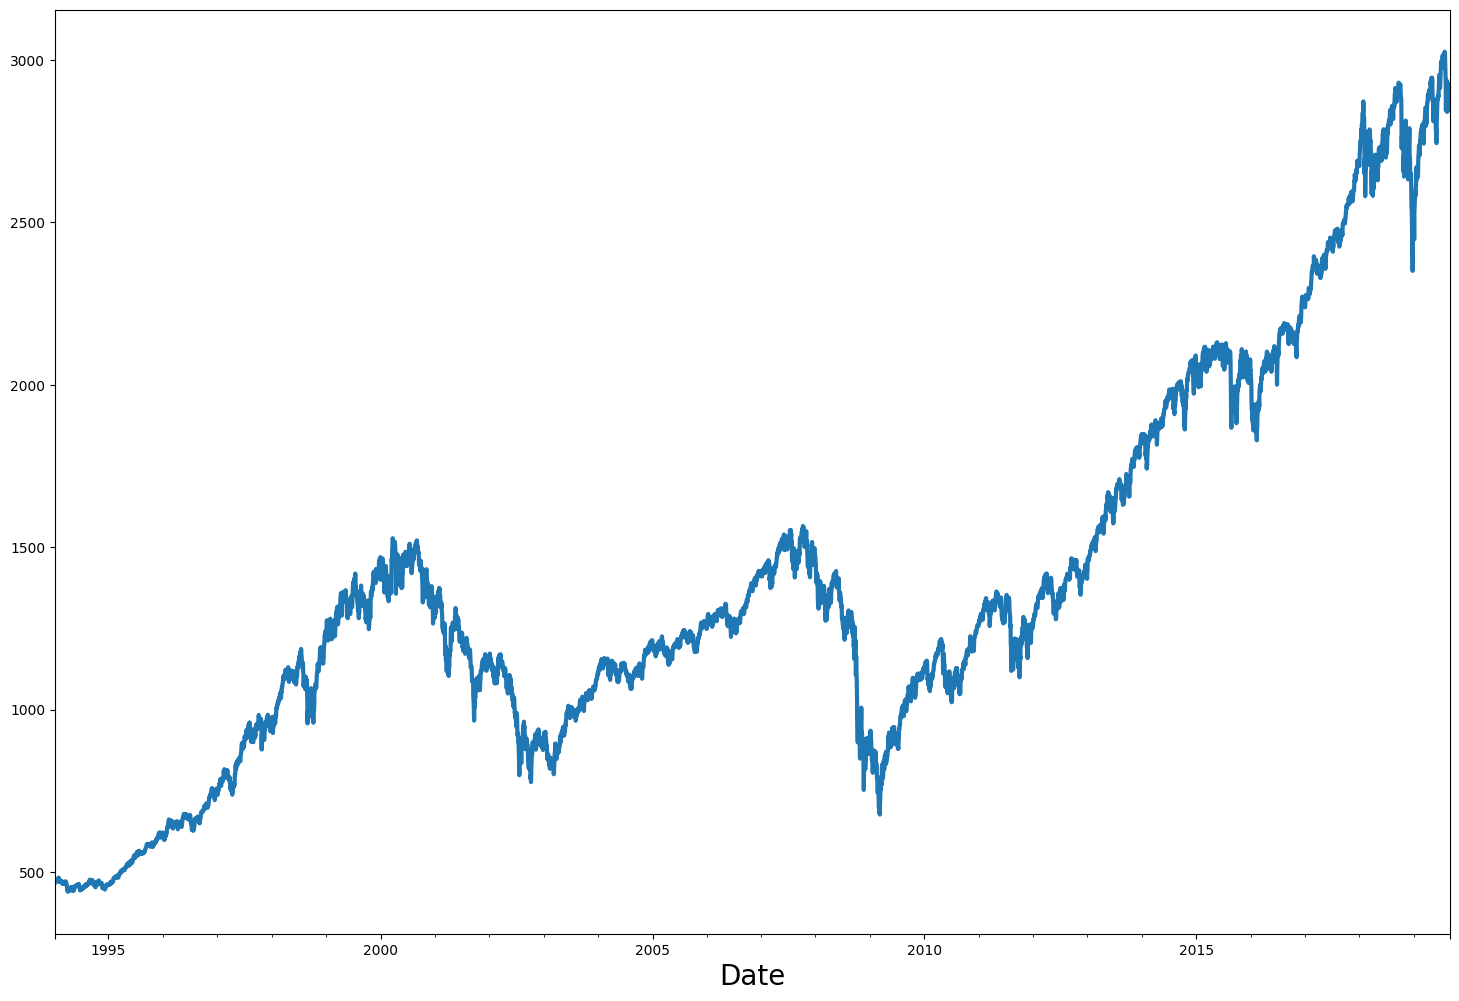

In [25]:
data.spx.plot()
plt.show()

(1339, 1)


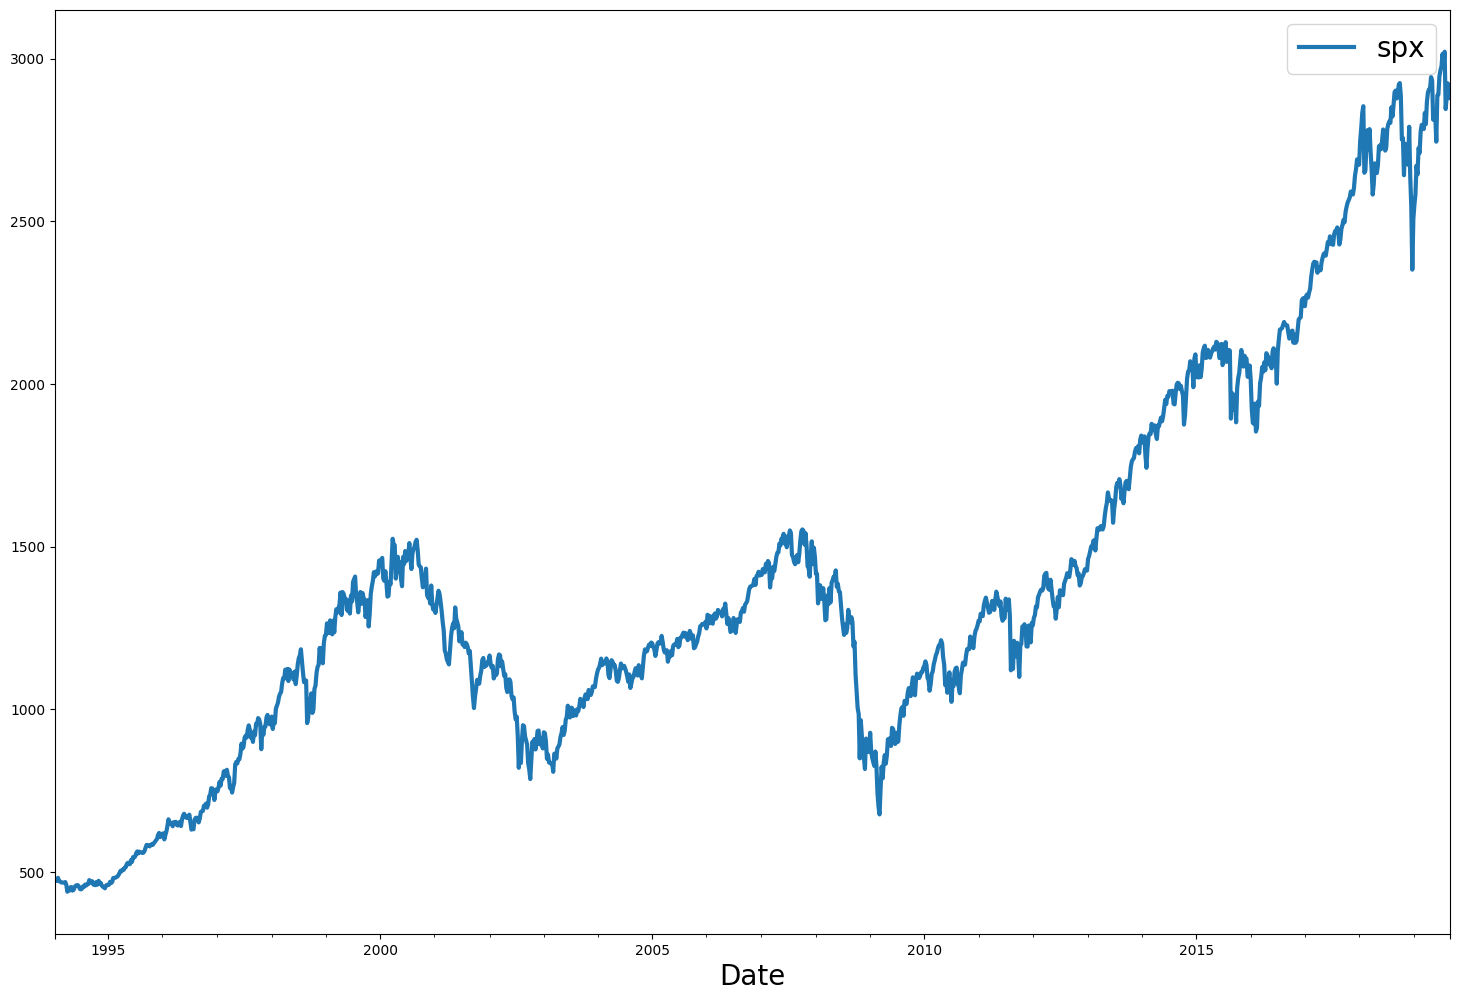

In [26]:
interpolated_data = pd.DataFrame(
    data.spx.resample("w-MON").interpolate(), columns=["spx"]
)

print(interpolated_data.shape)
interpolated_data.plot()
plt.show()

In [27]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [28]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

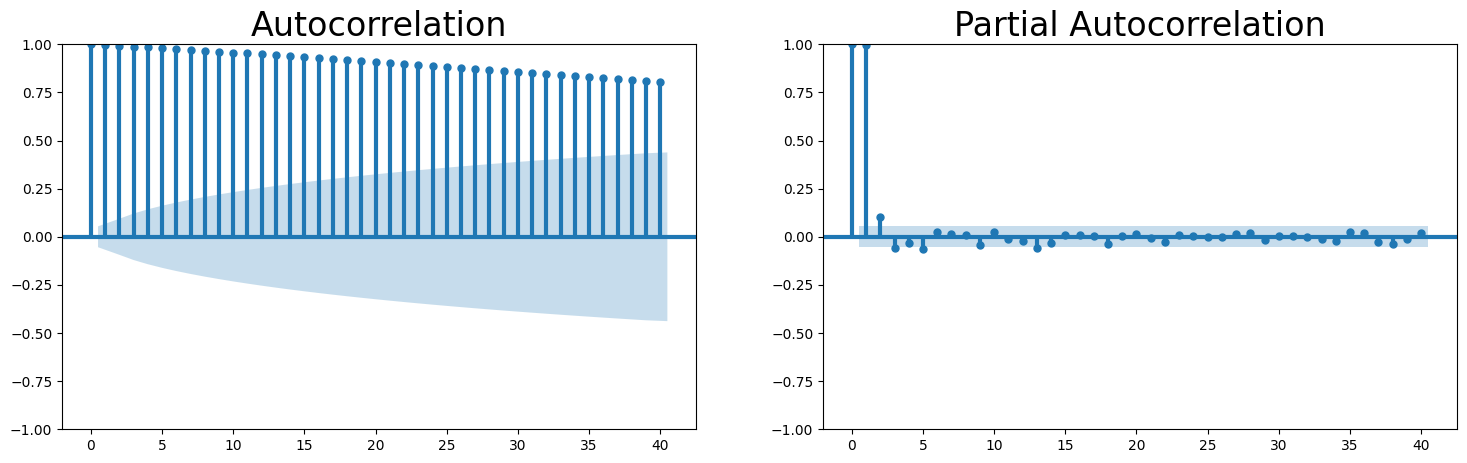

(-0.26076571431167433,
 0.9308801996019753,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [29]:
import statsmodels.graphics.tsaplots as sgt

plot_acf_pacf(train_df["spx"].dropna())
adfuller(train_df["spx"].dropna())

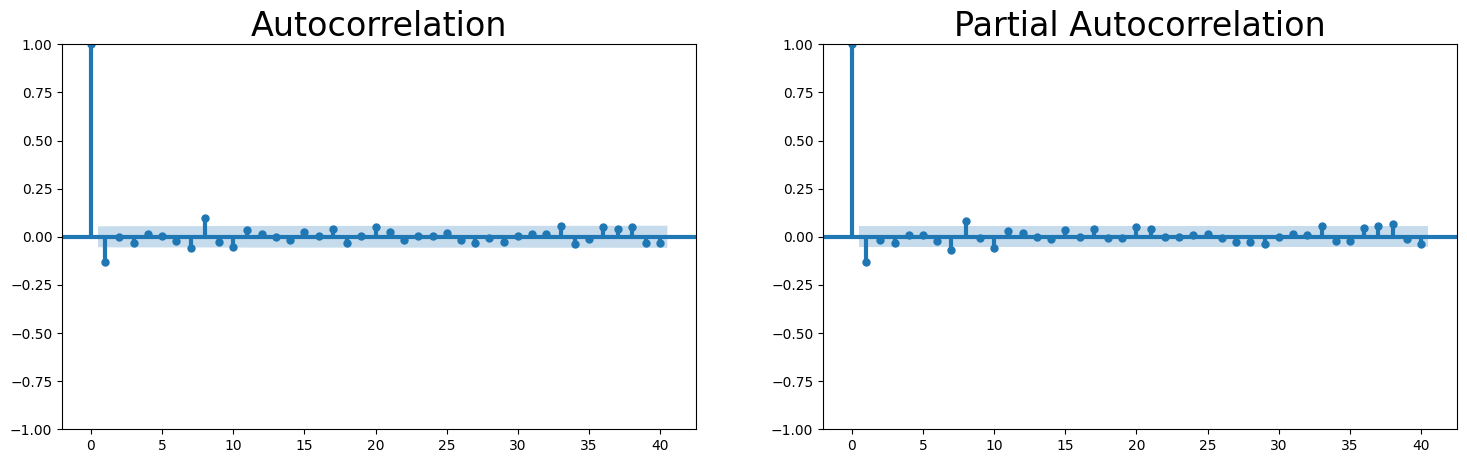

(-11.946377875600563,
 4.420358877553233e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [30]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6359.035
Date:                Thu, 21 Sep 2023   AIC                          12724.070
Time:                        12:52:59   BIC                          12739.587
Sample:                    01-10-1994   HQIC                         12729.891
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      0.137      0.157      0.875      -0.247       0.290
ma.L1         -0.1545      0.132     -1.173      0.241      -0.413       0.104
sigma2      1015.0733     20.021     50.701      0.000     975.833    1054.314
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2373.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
pred_df = pd.DataFrame(index=interpolated_data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

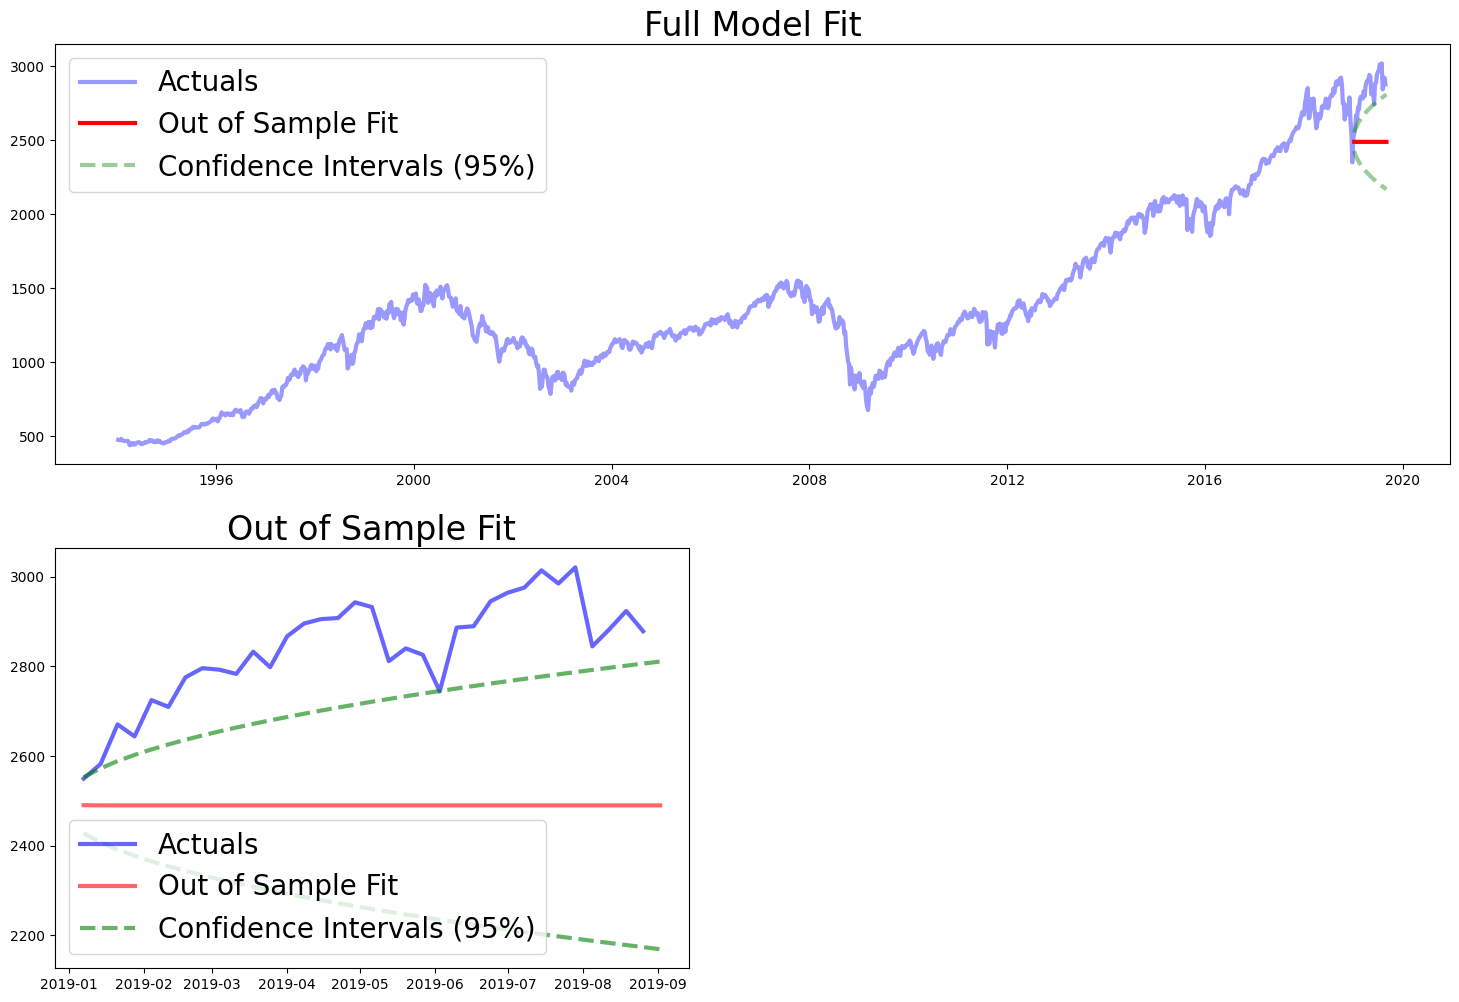

In [33]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

## Волатильность 

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [34]:
# data["spx_vol"] = (data.spx - data.spx.shift(1))/data.spx.shift(1)
data["spx_vol"] = data.spx.pct_change(1).mul(100).abs()
data["spx_vol"].head()

Date
1994-01-06         NaN
1994-01-07    0.595136
1994-01-10    1.142795
1994-01-11    0.239860
1994-01-12    0.008438
Name: spx_vol, dtype: float64

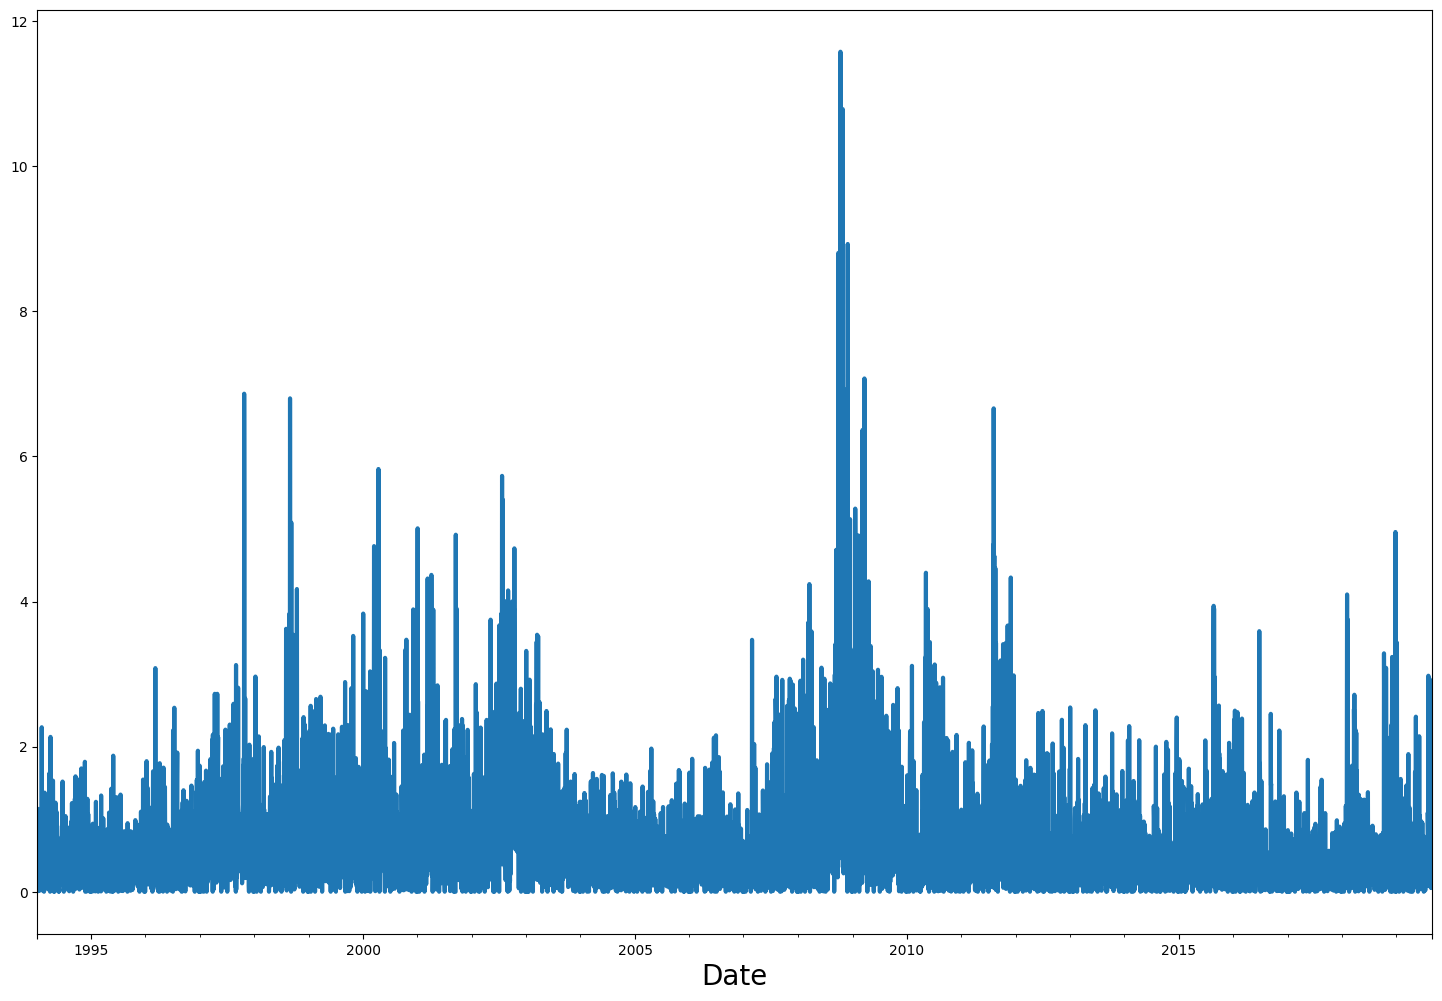

In [35]:
data["spx_vol"].plot()
plt.show()

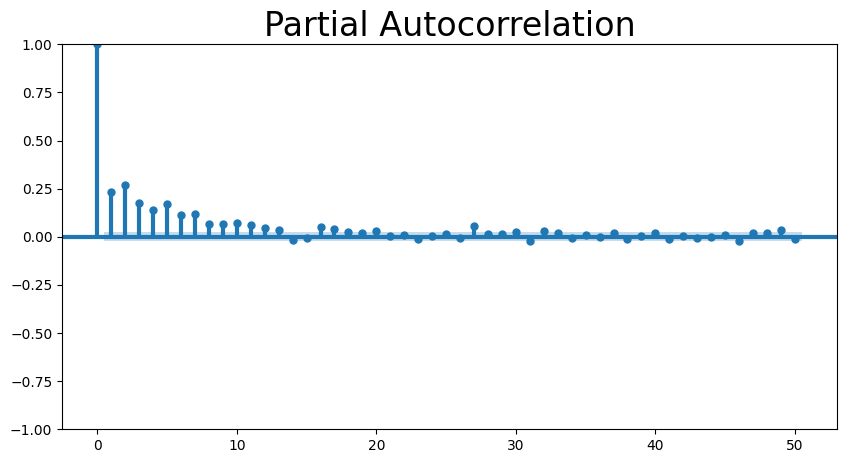

In [36]:
from matplotlib import pyplot as plt

train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.spx_vol[1:], lags=50, method="ywm")
plt.show()

In [37]:
adfuller(train_df.spx_vol[1:])

(-6.395349225292415,
 2.057355456189679e-08,
 32,
 6484,
 {'1%': -3.4313589282423522,
  '5%': -2.8619858596459524,
  '10%': -2.567007327763762},
 14596.425117785417)

Глядя на графики PACF для доходности и волатильности, становится ясно, что самый значтельный - 2 лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(2, 2).

In [40]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["spx_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "spx_vol"] = train_df["spx_vol"].dropna()

In [41]:


from arch import arch_model

model = arch_model(garch_df["spx_vol"].dropna(), p=2, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     50,   Neg. LLF: 7099.667418348945
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6534.228743128515
Iteration:     15,   Func. Count:    128,   Neg. LLF: 6509.361021682806
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6509.361009226598
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17


In [42]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6509.36
Distribution:                  Normal   AIC:                           13030.7
Method:            Maximum Likelihood   BIC:                           13071.4
                                        No. Observations:                 6517
Date:                Thu, Sep 21 2023   Df Residuals:                     6516
Time:                        12:55:50   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5505  1.077e-02     51.120      0.000 [  0.529,  0.572]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0137  3.619e-03      3.773  1.611e-04 [6.563e-03,2.075e-02]
alpha[1]       0.0704  1.850e-02      3.803  1.428e-04   [3.410e-02,  0.107]
alpha[2]       0.1162  2.731e-02      4.256  2.079e-05   [6.271e-02,  0.170]
beta[1]        0.1568  8.870e-02      1.768  7.710e-02  [-1.705e-02,  0.331]
beta[2]        0.6444  8.451e-02      7.626  2.430e-14     [  0.479,  0.810]
============================================================================

Covariance estimator: robust
"""

In [43]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

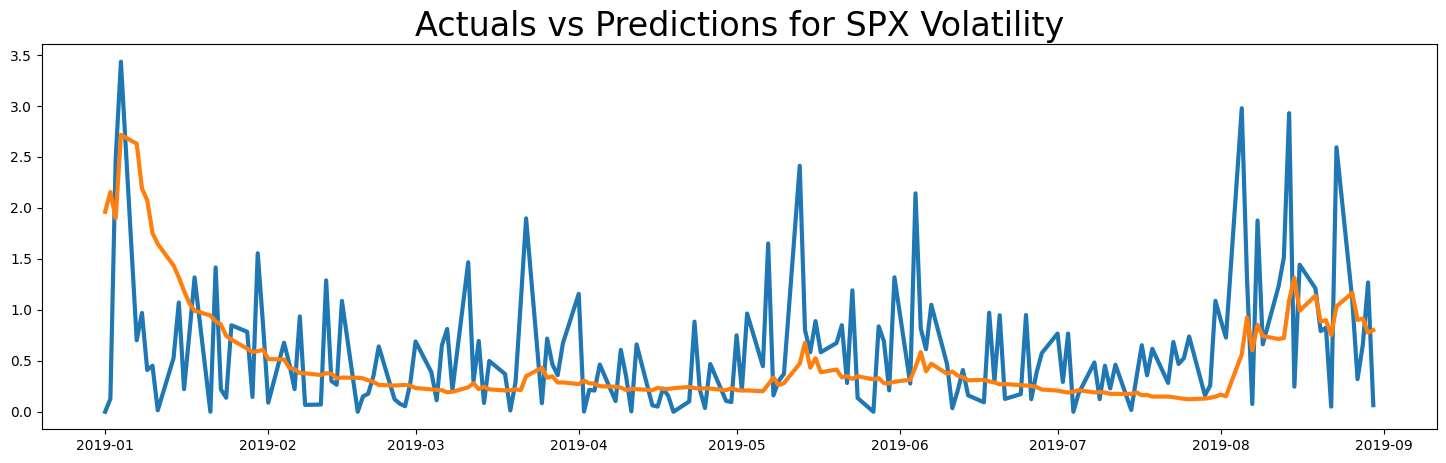

In [44]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["spx_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [45]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["spx_vol"].abs(), predictions_df["Predictions"]
)

0.42091182757196083

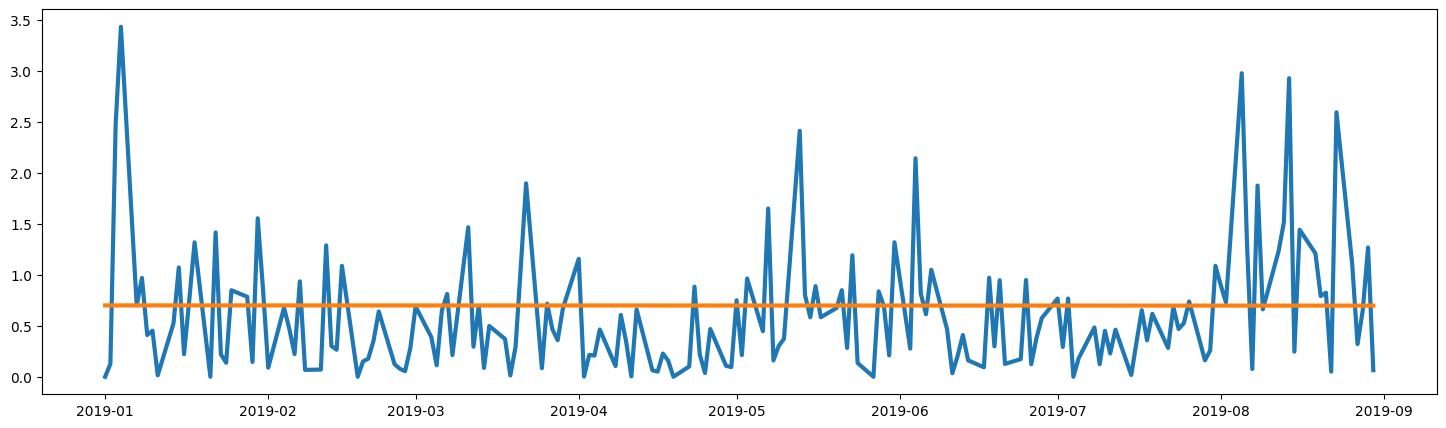

In [46]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["spx_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["spx_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["spx_vol"].fillna(0)
y_test = test_df["spx_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()